Lawrence Huang

Introduction to Computational Physics

Final Project

In [1]:
from scipy import ndimage
import numpy as np
from numpy import sin, cos, pi

import matplotlib as mlp
import matplotlib.pyplot as plt

from datetime import datetime

# Setting constants and initial conditions

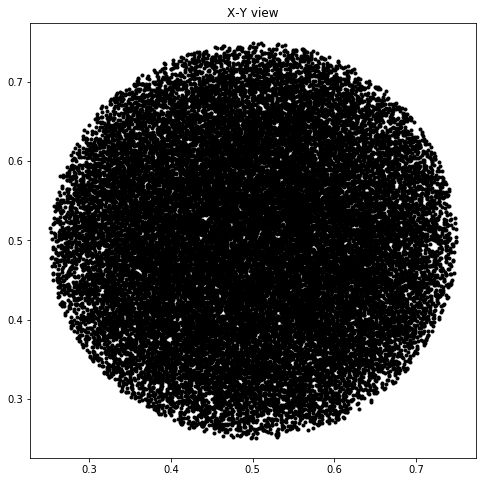

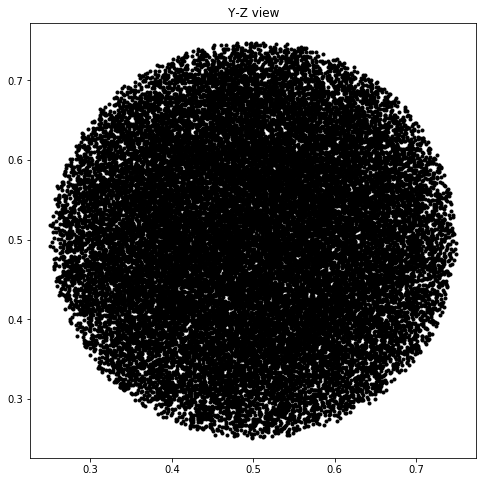

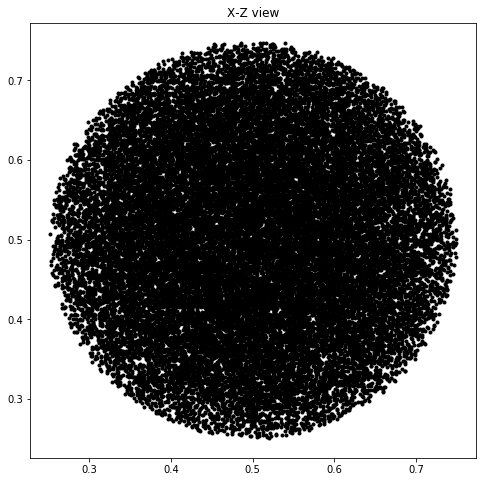

In [2]:
np.random.seed(1)
Nc = 128
Np = 32**3
m = 0.1
L = 1
width = L/Nc
G = 6.67408 * 10**-11
kernel = np.zeros((Nc,Nc,Nc//2 + 1))

for i in range(Nc):
    for j in range(Nc):
        for k in range(Nc//2 + 1):
            if i <= Nc/2:
                kx = (2*pi/Nc)*i
            elif i > Nc/2:
                kx = (2*pi/Nc)*(i-Nc)
            if j <= Nc/2:
                ky = (2*pi/Nc)*j
            elif j > Nc/2:
                ky = (2*pi/Nc)*(j-Nc)
            kz = (2*pi/Nc)*k
            if i == 0 and j == 0 and k == 0:
                kernel[i,j,k] = 0
            else:
                kernel[i,j,k] = -4*pi*G/((2*sin(kx/2))**2 + (2*sin(ky/2))**2 + (2*sin(kz/2))**2)
            

def generateSphere():
    result = np.empty((Np, 9))
    #x y z vx vy vz ax ay az
    sphereCoords = np.random.rand(Np,3)
    
    #set 0 <= radius <= 1/4 Meters
    #Transforming uniform distribution to desired distribution for radius
    sphereCoords[:,0] *= 3
    sphereCoords[:,0] = sphereCoords[:,0]**(1/3)
    sphereCoords[:,0] *= (L/4)/(3**(1/3))
    

    
    #set 0 <= theta <= pi
    #Transforming uniform distribution to desired distribution for theta
    sphereCoords[:,1] = sphereCoords[:,1]*2 - 1
    sphereCoords[:,1] = np.arccos(-sphereCoords[:,1])
    

    
    
    
    
    #set 0 <= phi <= 2*pi
    sphereCoords[:,2] *= 2*pi

    
    #Transforming from spherical to cartesian
    
    xs = sphereCoords[:,0]*sin(sphereCoords[:,1])*cos(sphereCoords[:,2])
    ys = sphereCoords[:,0]*sin(sphereCoords[:,1])*sin(sphereCoords[:,2])
    zs = sphereCoords[:,0]*cos(sphereCoords[:,1])
    result[:,0] = xs
    result[:,1] = ys
    result[:,2] = zs
    result[:,3:6] = 0
    result[:,0:3] += 0.5
    return result
    
part = generateSphere()
plt.figure(figsize=(8,8))
plt.title("X-Y view")
plt.plot(part[:,0],part[:,1], "k.")
plt.show()

plt.figure(figsize=(8,8))
plt.title("Y-Z view")
plt.plot(part[:,1],part[:,2], "k.")
plt.show()

plt.figure(figsize=(8,8))
plt.title("X-Z view")
plt.plot(part[:,0],part[:,2], "k.")
plt.show()

# Defining function for mass allocation, proportions(x) and a CIC function to produce density

In [3]:
def proportions(x):
    x = x % (1/128)
    result = np.array([
            128*(1/256 - x),
            1 - 128*abs(x-1/256),
            128*(x-1/256)
        ])
    result[ result < 0] = 0
    return result


def CIC(part):

    density = np.zeros((Nc,Nc,Nc))
    x = part[:,0]
    y = part[:,1]
    z = part[:,2]
    xIndex = (x*128).astype(int)
    yIndex = (y*128).astype(int)
    zIndex = (z*128).astype(int)
    xProportions = proportions(x)
    yProportions = proportions(y)
    zProportions = proportions(z)
    
    for dx in range(-1,2):
            for dy in range(-1,2):
                for dz in range(-1,2):
                    np.add.at(density,[(xIndex + dx)%128, (yIndex + dy)%128, (zIndex + dz)%128],
                              xProportions[1+dx]*yProportions[1+dy]*zProportions[1+dz])
    

    
    
    

    #To get density in units of mass per unit volume
    #Each cell is a cube of side length 1/128 meters
    vol = (1/128)**3
    density = m*density/vol
    checkMass(part.shape[0], density)
    return density
    

def checkMass(num, density):
    assert(np.isclose(np.sum(density)*(1/128)*(1/128)*(1/128), num*m).all())
    

# Function to get potential using density

In [4]:
def getPotential(density):
    p = np.fft.rfftn(density)
    potential = p*kernel
    potential = np.fft.irfftn(potential)
    potential = potential.real
    return potential.real
    

# One Particle Test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


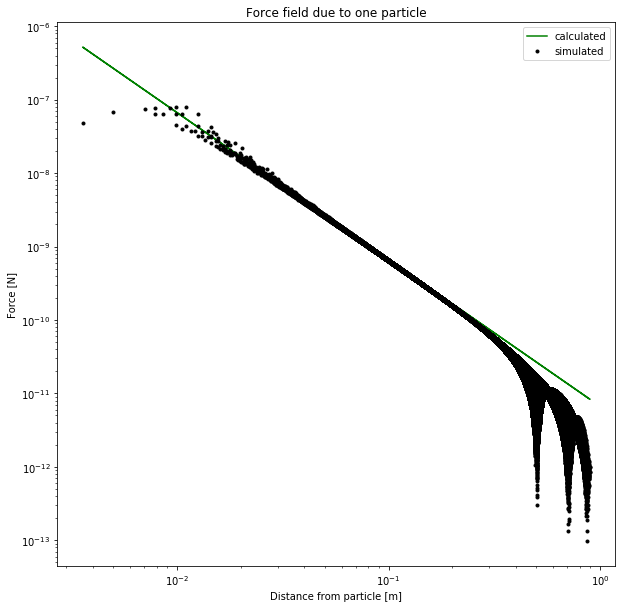

In [5]:
    
def forceField(potential):
    f = np.zeros((Nc,Nc,Nc,3))
    for i in range(Nc):
        for j in range(Nc):
            for k in range(Nc):
                f[i,j,k,0] = (potential[(i+1) % Nc ,j,k] - potential[i-1,j,k])/(2/128)
                f[i,j,k,1] = (potential[i,(j+1) % Nc,k] - potential[i,j-1,k])/(2/128)
                f[i,j,k,2] = (potential[i,j,(k+1) % Nc] - potential[i,j,k-1])/(2/128)
    f = f/(128**2.007)
    return f

def oneParticleTest():
    part = np.array([[63.4/128,60.3/128,67.9/128, 0, 0, 0, 0, 0 ,0]])
    density = CIC(part)
    potential = getPotential(density)
    forces = forceField(potential)
    rs = []
    fs = []
    for i in range(Nc):
        for j in range(Nc):
            for k in range(Nc):
                rs.append(np.sqrt( (i/128+1/256 - part[0,0])**2 + (j/128+1/256 - part[0,1])**2 + (k/128+1/256 - part[0,2])**2))
                fs.append(np.sqrt(forces[i,j,k,0]**2 + forces[i,j,k,1]**2 + forces[i,j,k,2]**2))
    rs = np.array(rs)
    fs = np.array(fs)
    guide = G*m/(rs**2)
    
    plt.figure(figsize=(10,10))
    plt.title("Force field due to one particle")
    plt.xlabel("Distance from particle [m]")
    plt.ylabel("Force [N]")
    plt.plot(rs, guide, "g", label="calculated")
    plt.plot(rs, fs, "k.",label="simulated")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.show()
    
oneParticleTest()

    


# Functions for finding forces on particles given potential field

In [6]:
def grad(potential, xIndex, yIndex, zIndex):
    result = np.array([
        (potential[(xIndex+1) % Nc,yIndex% Nc,zIndex% Nc] - potential[(xIndex-1)% Nc,yIndex% Nc,zIndex% Nc]),
        (potential[xIndex% Nc,(yIndex+1) % Nc,zIndex% Nc] - potential[xIndex% Nc,(yIndex-1)% Nc,zIndex% Nc]),
        (potential[xIndex% Nc,yIndex% Nc,(zIndex+1) % Nc] - potential[xIndex% Nc,yIndex% Nc,(zIndex-1)% Nc])
    ])
    
    result = result/(2/128)
    result = result
    
    return result
    

def pointForce(potential, x, y, z):
    xIndex = (x/(1/128)).astype(int)
    yIndex = (y/(1/128)).astype(int)
    zIndex = (z/(1/128)).astype(int)
    
    xIndex = (xIndex)
    yIndex = (yIndex)
    zIndex = (zIndex)
    xProportions = proportions(x)
    yProportions = proportions(y)
    zProportions = proportions(z)
    f = np.zeros((3,x.shape[0]))
    for a in range(-1,2):
        for b in range(-1,2):
            for c in range(-1,2):
                f += -1*xProportions[a+1]*yProportions[b+1]*zProportions[c+1]*grad(potential, xIndex+a, yIndex+b, zIndex+c)

    f = f/(128**2.007)
    
    return f



def acceleration(potential, part):
    part[:,6:] = 0
    x = part[:,0]
    y = part[:,1]
    z = part[:,2]

    acc =  pointForce(potential,x,y,z)
    return np.flip(np.rot90(acc),0)



# Functions to determine time step and predict next positions and velocities using Verlet Method's Kick Drift Kick

In [7]:
def verlet(part, deltaT):
    #kick to v_n+0.5
    part[:,3:6] += part[:,6:9]*deltaT/2
    
    #drift to x_n+1 and a_n+1
    part[:,0:3] += part[:,3:6]*deltaT
    part[:,0:3] = part[:,0:3] % 1
    
    density = CIC(part)
    potential = getPotential(density)
    part[:,6:] = acceleration(potential, part)
    
    #kick to v_n+1
    part[:,3:6] += part[:,6:9]*deltaT/2
    
    return part
    
def timeStep(part):
    velocities = np.sqrt(part[:,3]**2 + part[:,4]**2 + part[:,5]**2)
    accelerations = np.sqrt(part[:,6]**2 + part[:,7]**2 + part[:,8]**2)
    vmax = np.max(velocities)
    amax = np.max(accelerations)
    if vmax == 0:
        deltaT = 0.5*np.sqrt(width/amax)
    else:
        deltaT = 0.5*np.minimum(width/vmax, np.sqrt(width/amax))
    return deltaT



# Functions for graphing data and organizing data to be displayed

In [8]:
def displayResults(part, t):
    plt.figure(figsize=(8,8))
    plt.title("X-Y view at time %f" %t)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot(part[:,0],part[:,1], "ko")
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.show()

    plt.figure(figsize=(8,8))
    plt.title("Y-Z view at time %f" %t)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot(part[:,1],part[:,2], "ko")
    plt.xlabel("Y [m]")
    plt.ylabel("Z [m]")
    plt.show()
    
    mP, mPRs = massProfile(part)
    rs = np.linspace(0,0.25,100)
    ys = Np*m*(rs/0.25)**3
    
    plt.figure(figsize=(8,8))
    plt.title("Mass Profile at time %f" %t)
    plt.ylabel("Mass enclosed [kg]")
    plt.xlabel("Radius [m]")
    plt.plot(mPRs, mP, label="Mass Profile")
    plt.plot(rs, ys, label="Initial Mass Profile")
    plt.legend()
    plt.show()

    aProfile, aRs = accelerationProfile(part)
    aExpected, aExpectedRs = expectedAccelerationProfile(mP, mPRs)

    plt.figure(figsize=(8,8))
    plt.title("Aceleration Profile at time %f" %t)
    plt.plot(aRs, aProfile, label="Acceleration Profile")
    plt.plot(aExpectedRs, aExpected, label="Expected Acceleration Profile")
    plt.ylabel("Acceleration [ms^-2]")
    plt.xlabel("Radius [m]")
    plt.legend()
    plt.show()
    
def massProfile(part):
    rs = np.sqrt((part[:,0] - 0.5)**2 + (part[:,1] - 0.5)**2 + (part[:,2] - 0.5)**2)
    mP, plotRs = np.histogram(rs, bins=100)
    mP = mP*0.1
    for i in range(mP.size-1,0,-1):
        mP[i] += np.sum(mP[:i])
    return mP, plotRs[1:]

def accelerationProfile(part):
    
    
    rs = np.sqrt((part[:,0] - 0.5)**2 + (part[:,1] - 0.5)**2 + (part[:,2] - 0.5)**2)
    accelerations = np.sqrt(part[:,6]**2 + part[:,7]**2 + part[:,8]**2)
    
    x = np.array([0.2, 6.4, 3.0, 1.6])
    bins = np.linspace(0,1,101)
    inds = np.digitize(rs, bins)
    counts = np.zeros(100)
    plotAs = np.zeros(100)
    plotRs = bins[1:]
    for n in range(rs.size):
        plotAs[int(bins[inds[n]]*100) - 1] += accelerations[n]
        counts[int(bins[inds[n]]*100) - 1] += 1
    counts[counts == 0] = 1
    plotAs = plotAs/counts
    return plotAs[plotAs != 0], plotRs[plotAs != 0]
    
    

def expectedAccelerationProfile(mP,mPRs):
    a = G*mP/(mPRs**2)
    return a, mPRs

# Master function

In [19]:
def master():
    #set initial conditions
    part = generateSphere()
    density = CIC(part)
    potential = getPotential(density)
    part[:,6:] = acceleration(potential, part)
    t = 0
    
    tDyn = np.sqrt((pi**2)*(0.25**3)/(4*G*Np*m))
    #0.05*tDyn is approximately 21
    mult = -1
    
    while t < tDyn:
        if t // 21 > mult:
            displayResults(part, t)
            mult = t // 21
        deltaT = timeStep(part)
        part = verlet(part, deltaT)
        
        
        t += deltaT
        
    return part

# Results

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


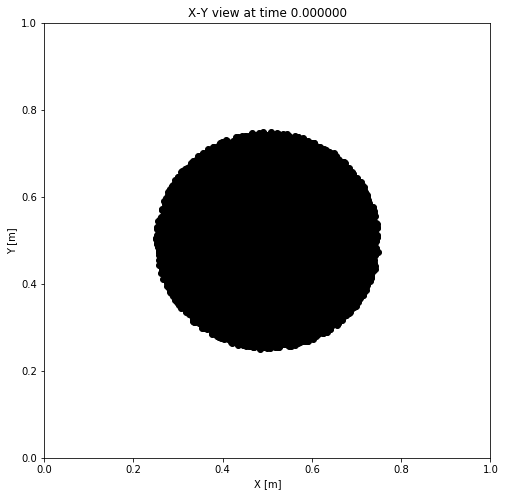

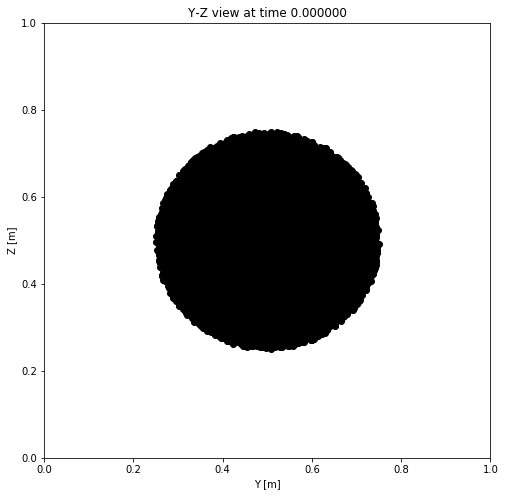

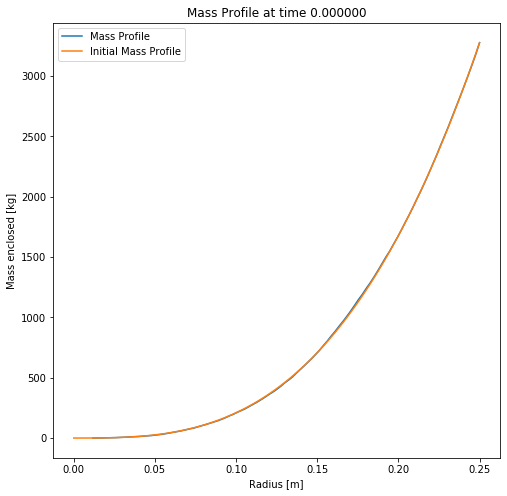

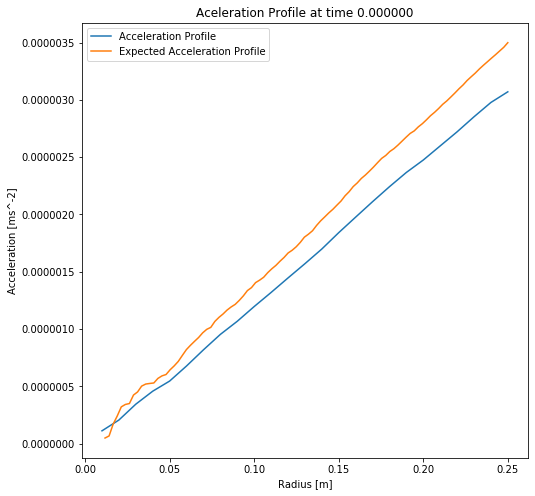

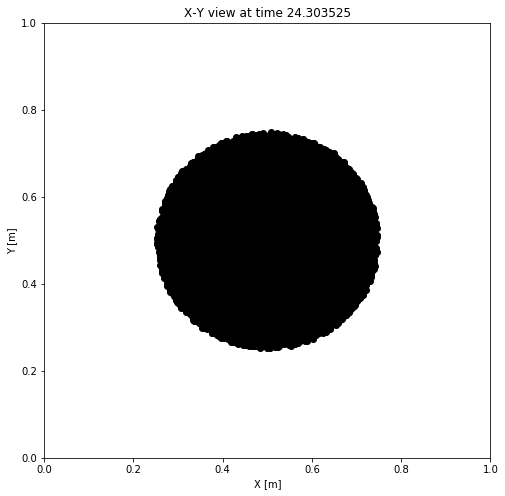

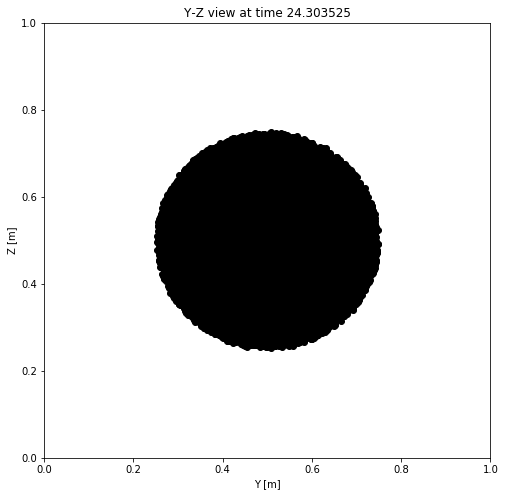

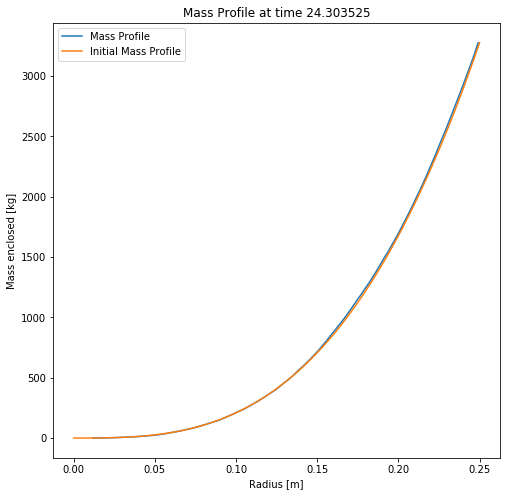

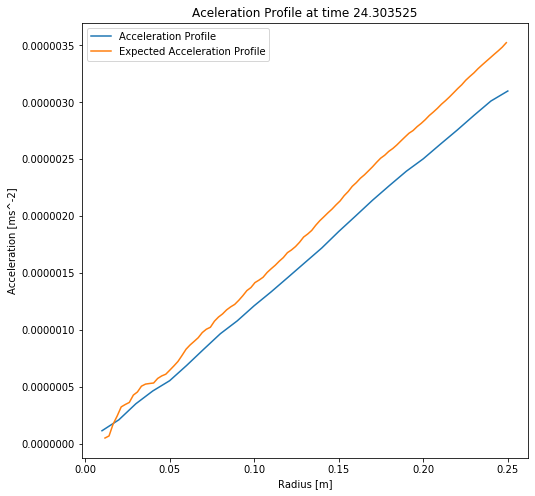

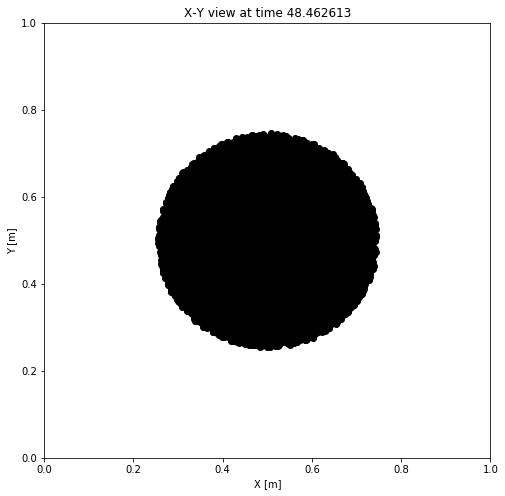

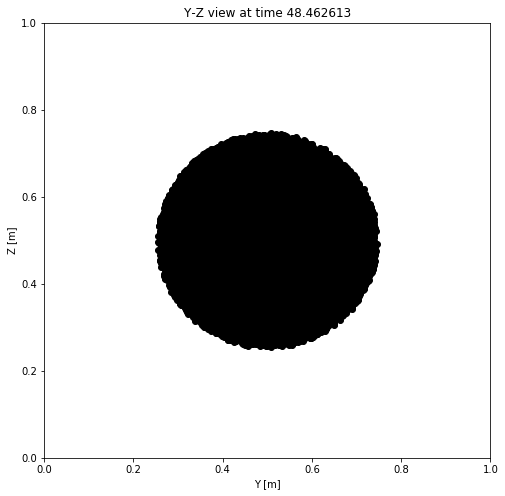

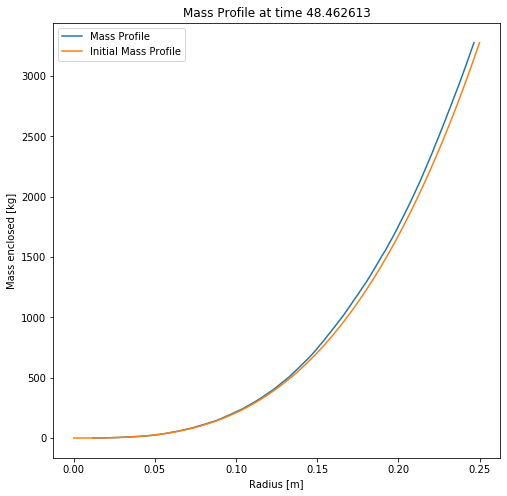

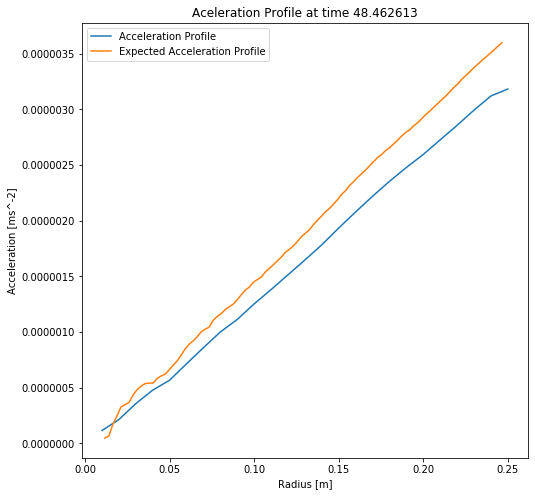

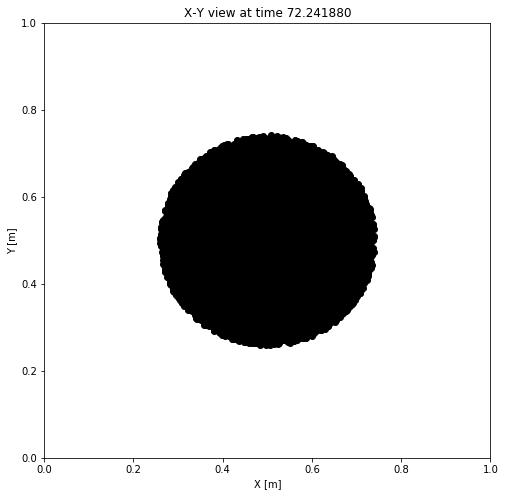

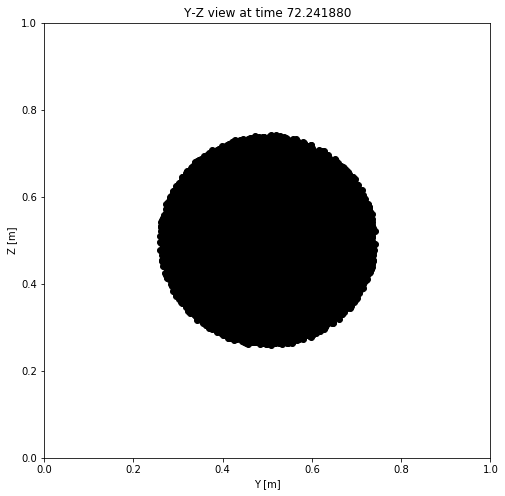

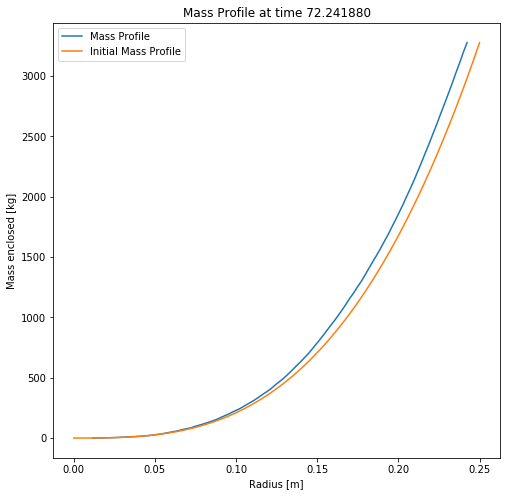

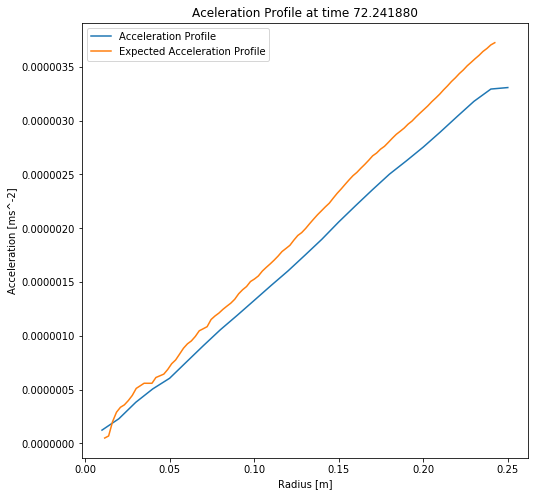

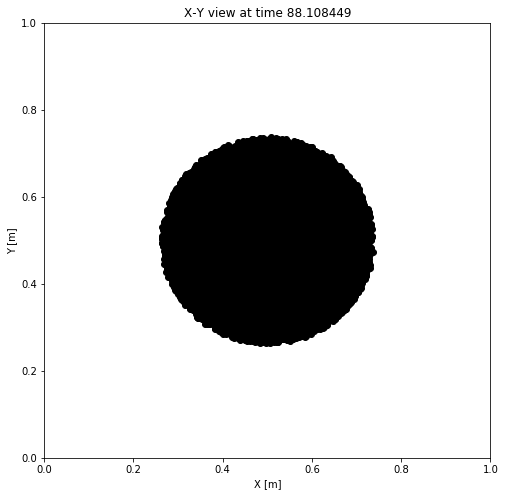

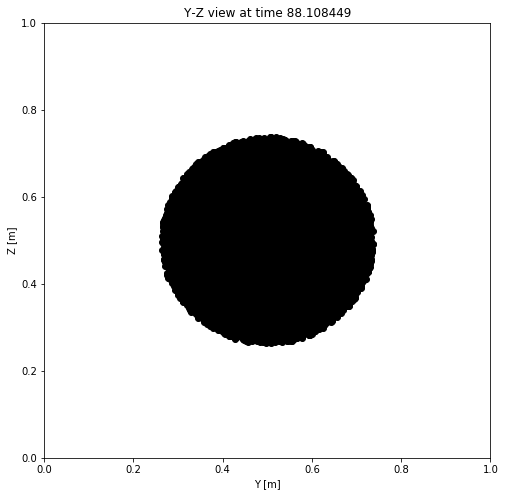

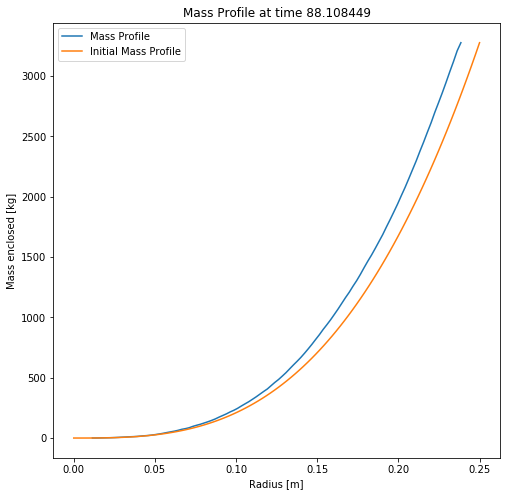

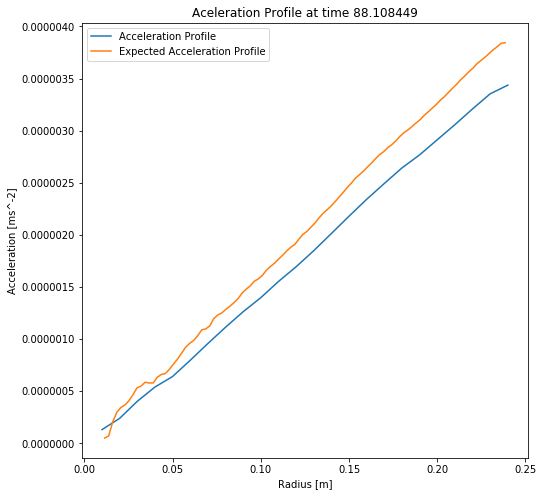

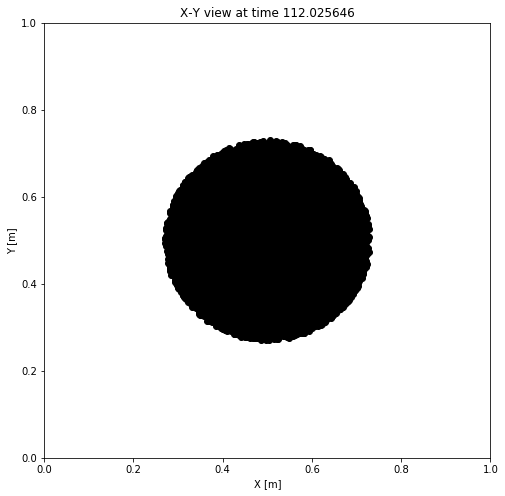

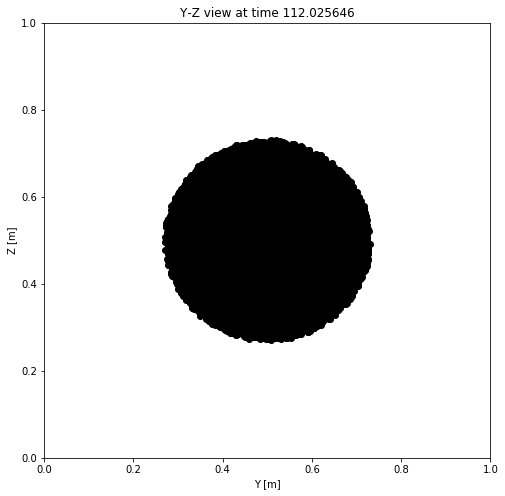

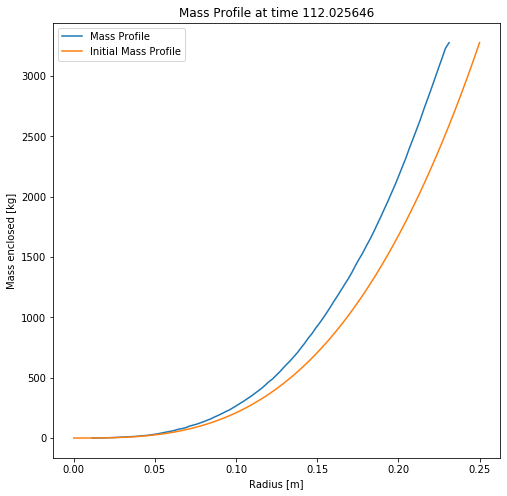

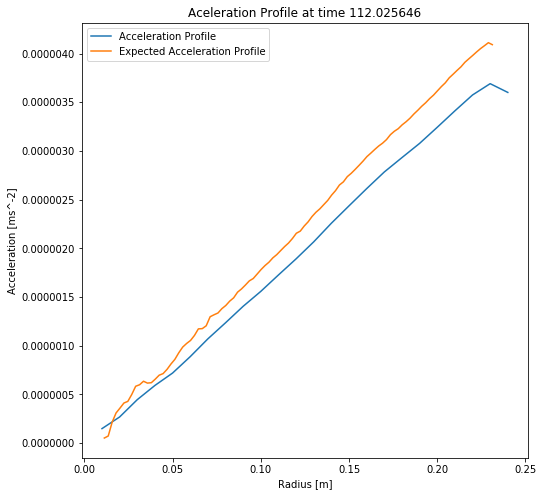

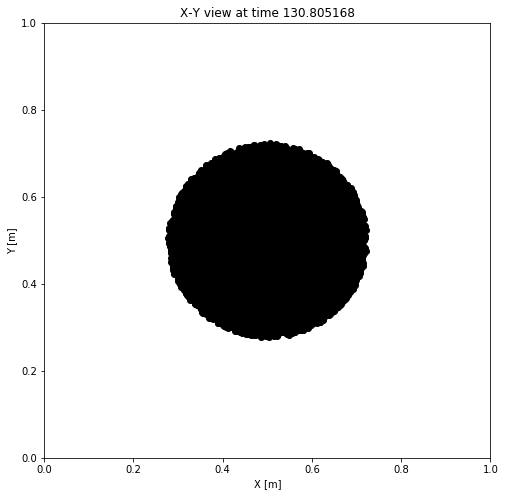

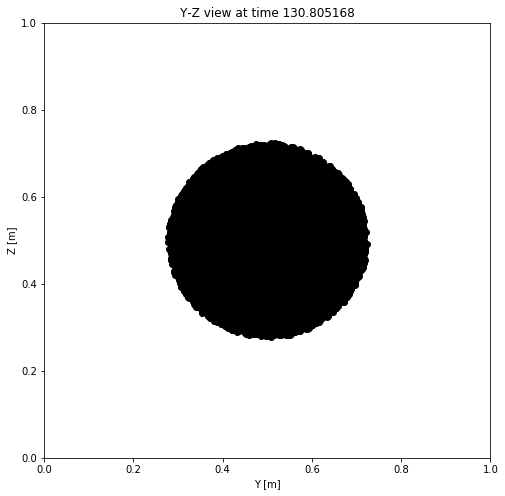

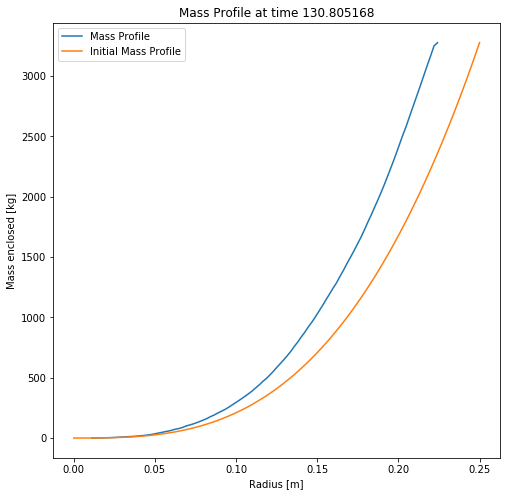

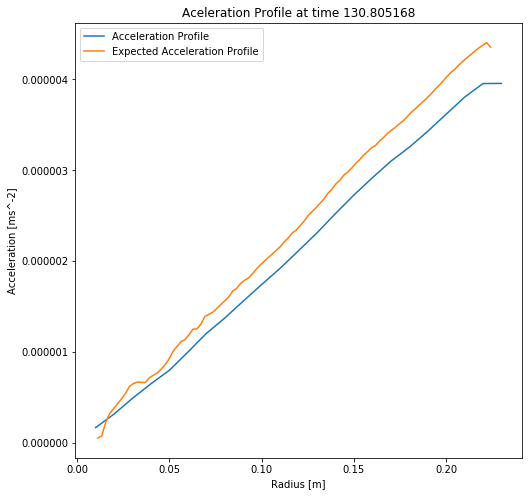

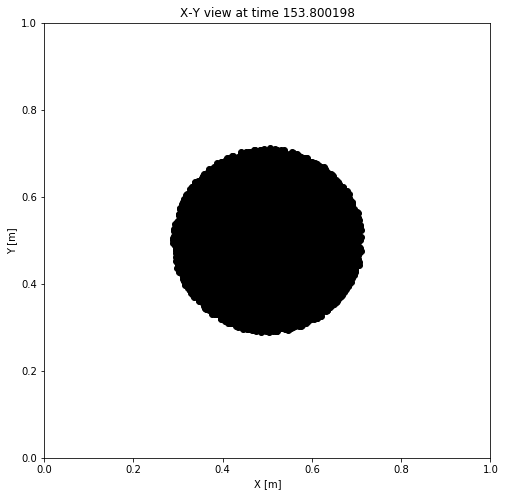

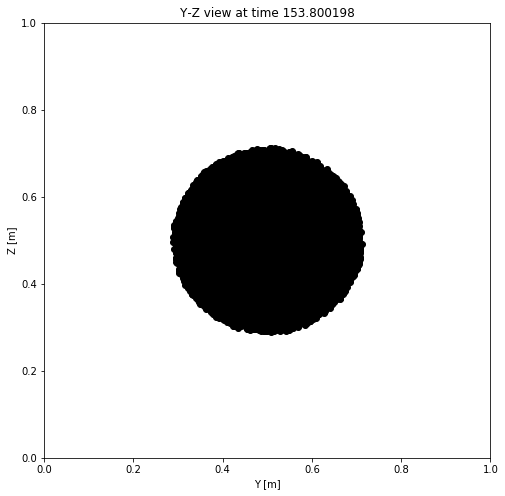

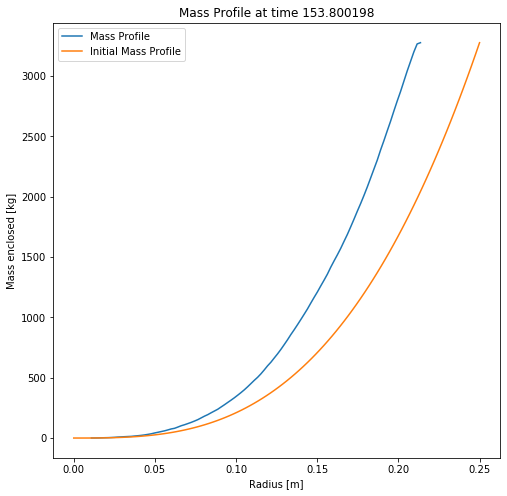

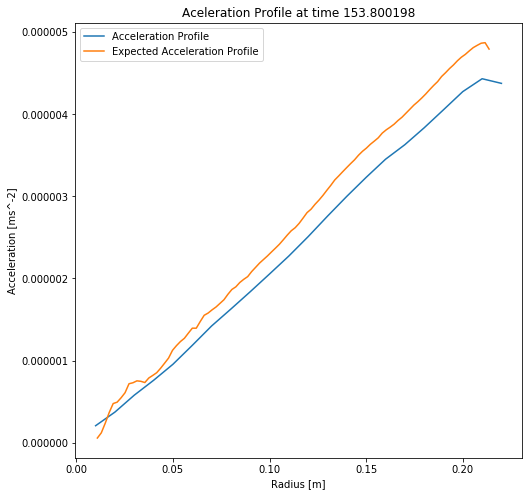

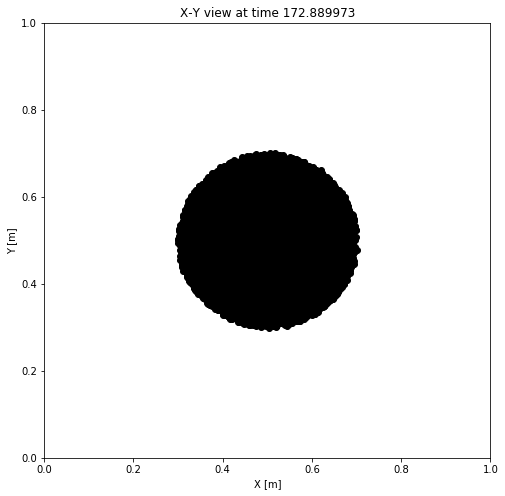

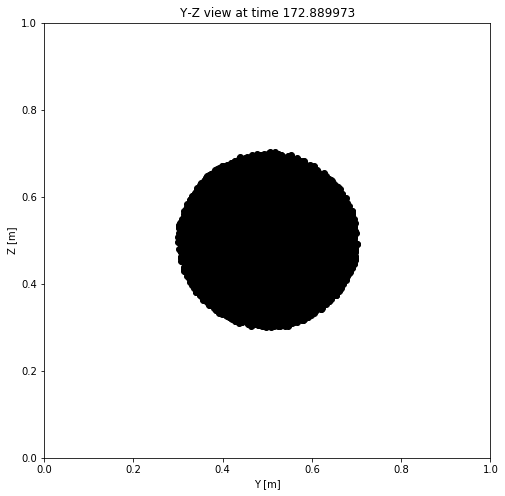

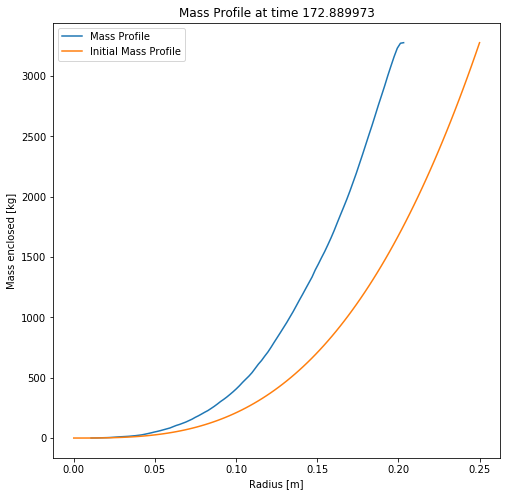

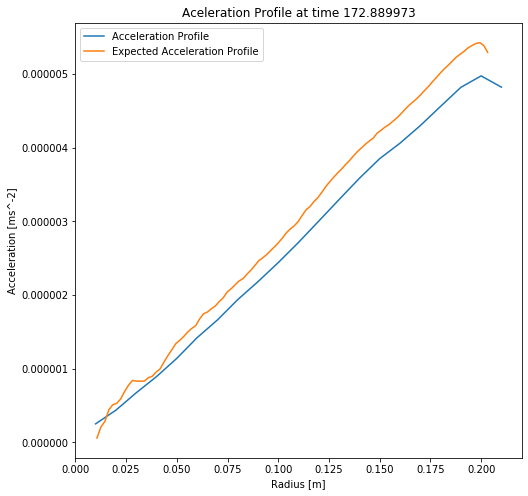

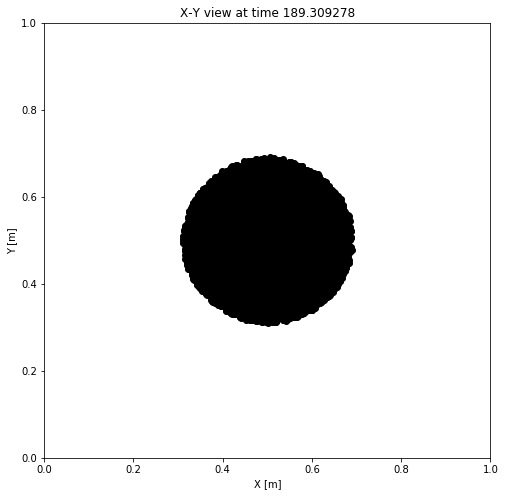

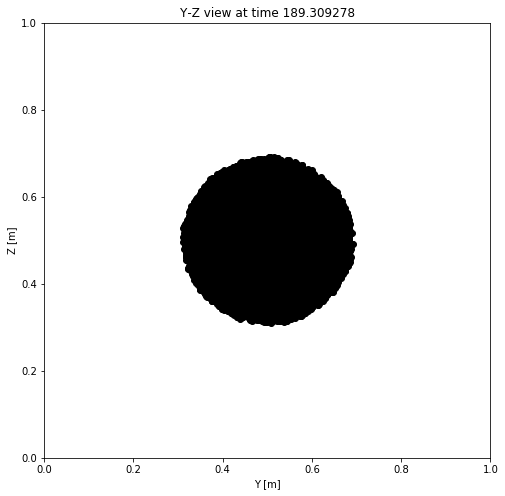

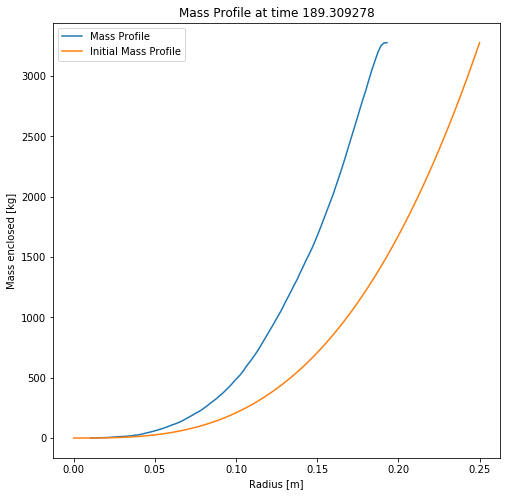

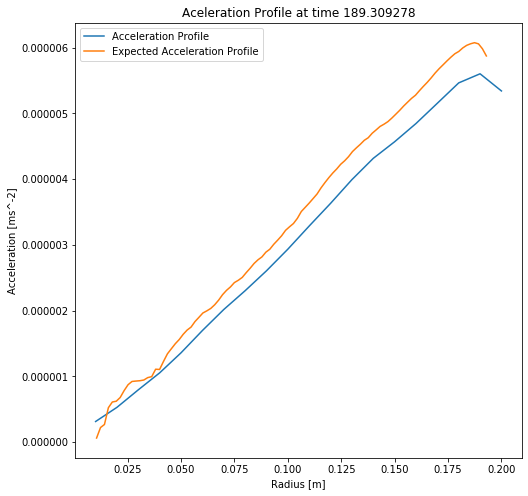

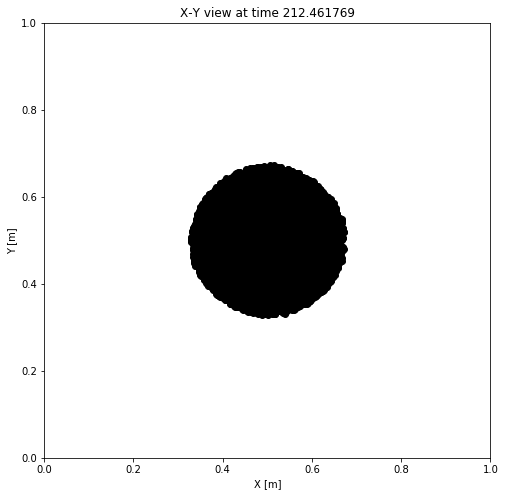

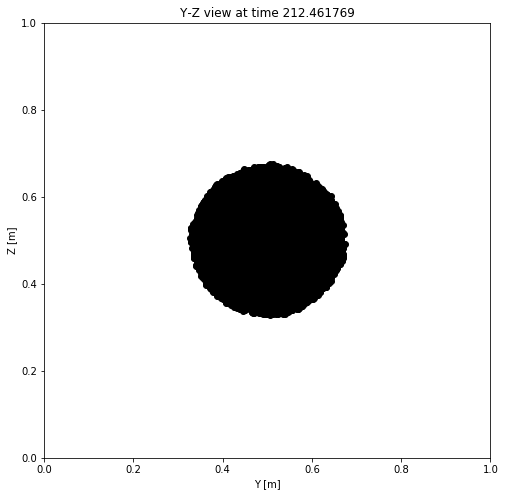

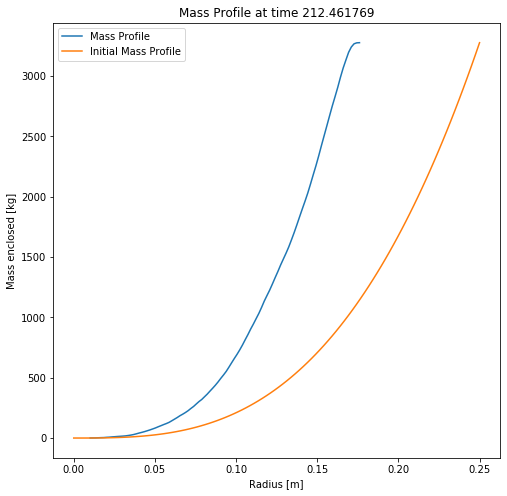

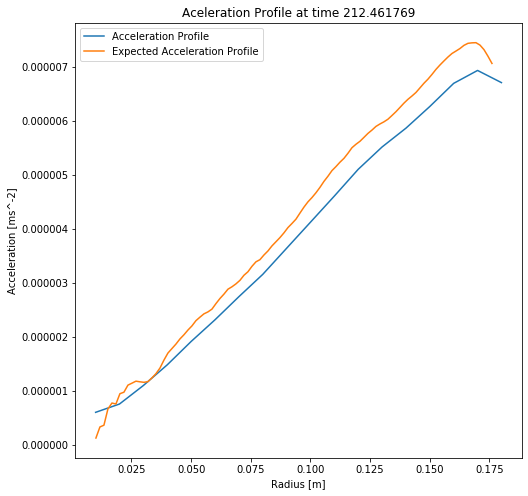

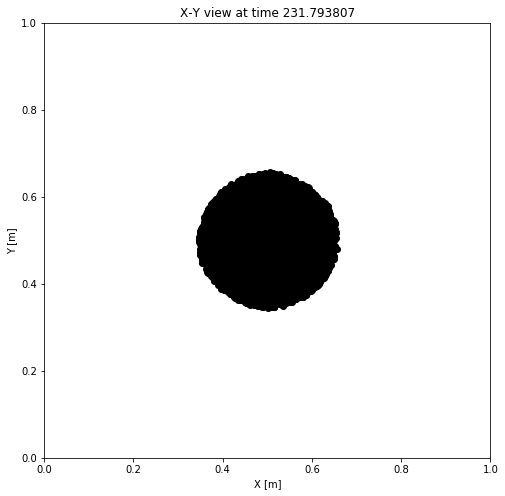

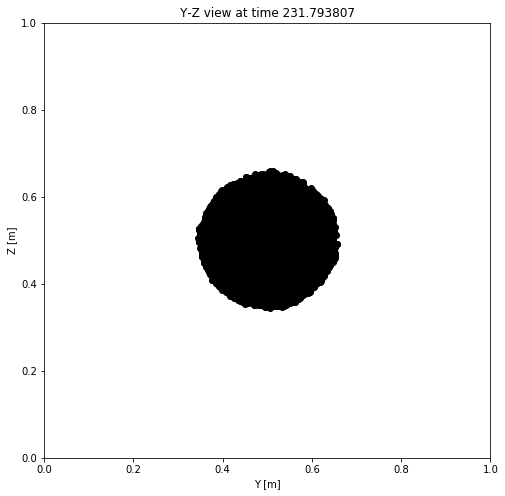

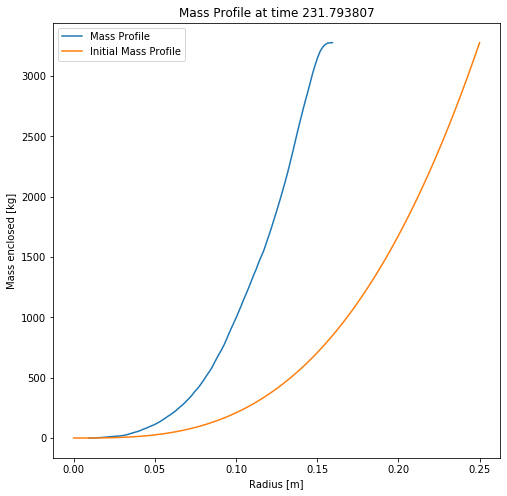

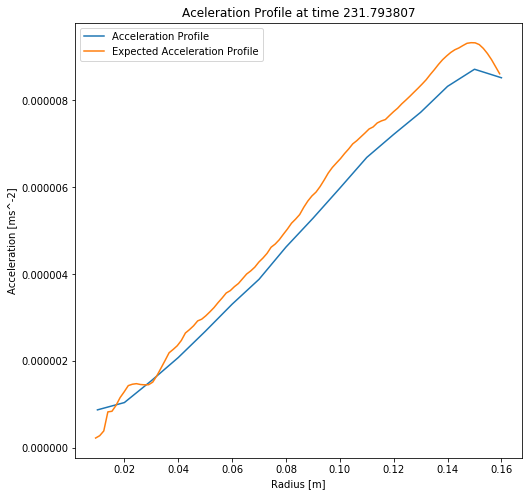

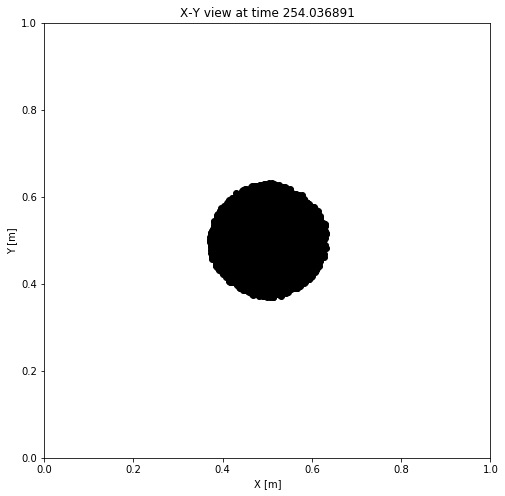

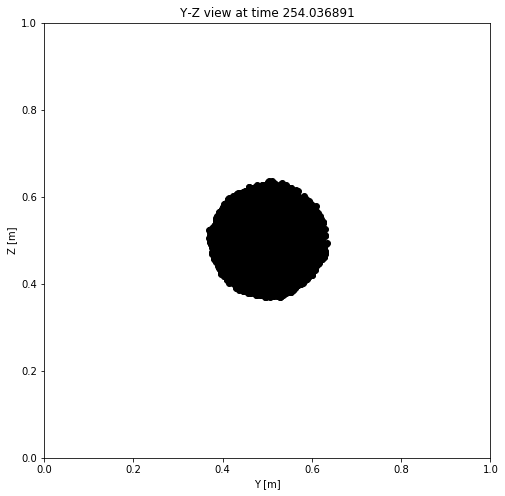

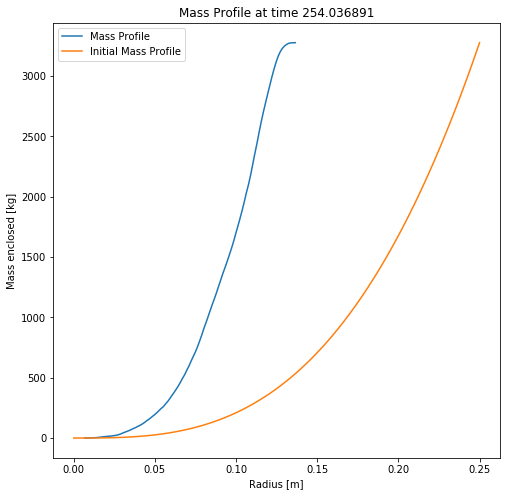

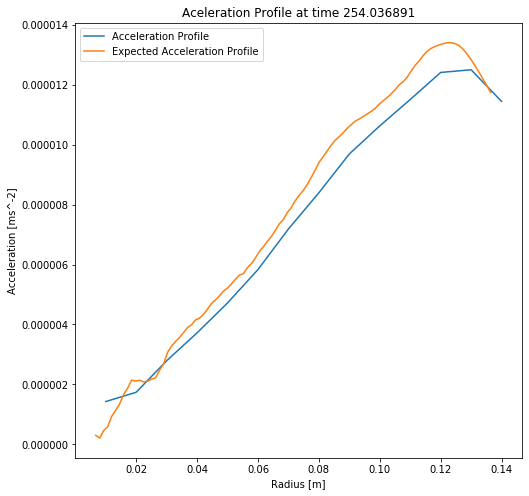

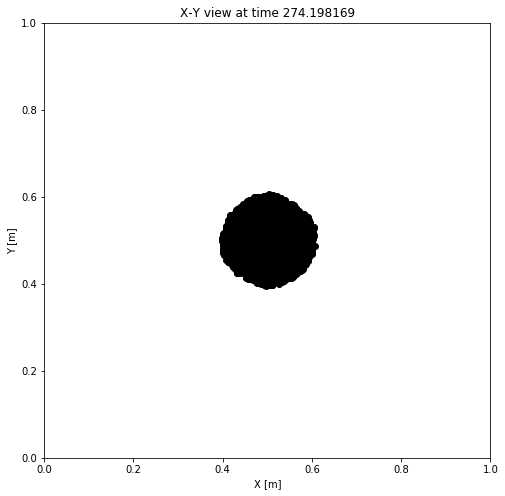

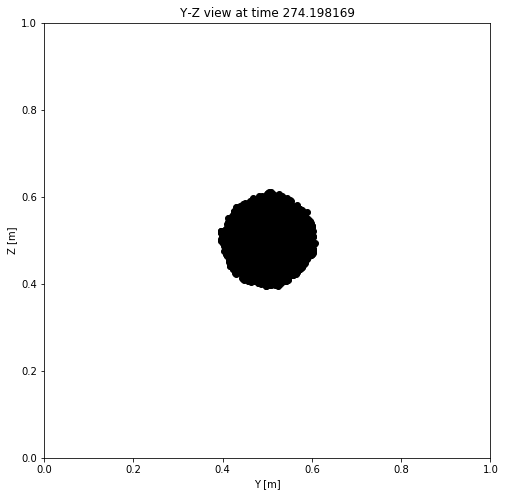

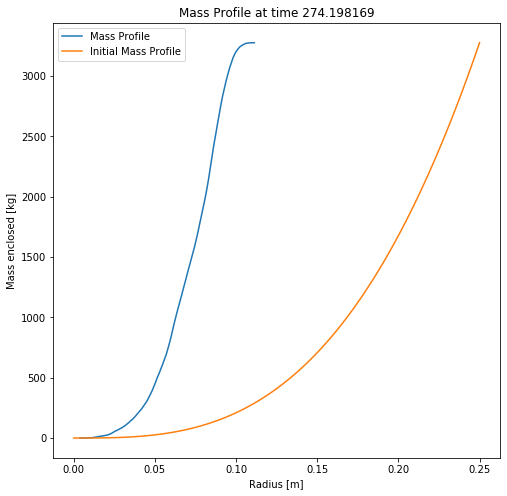

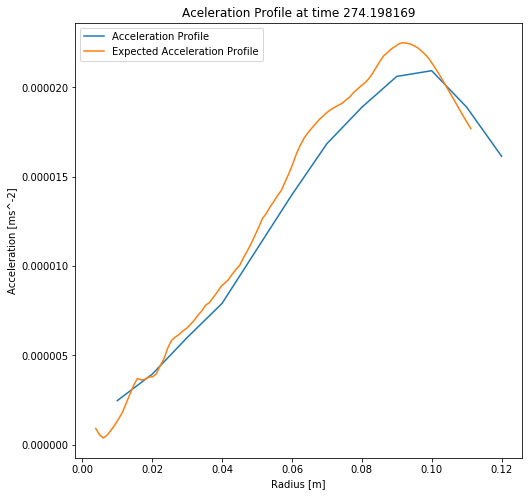

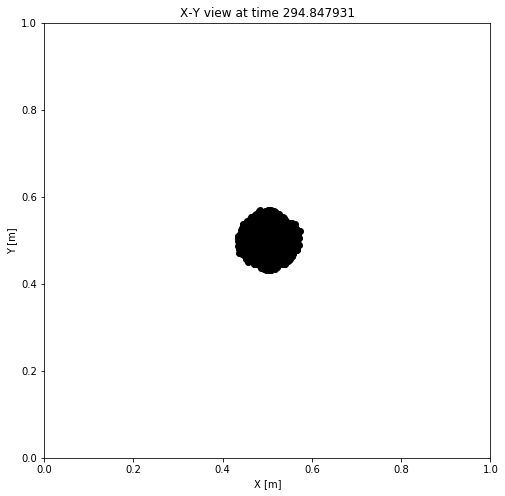

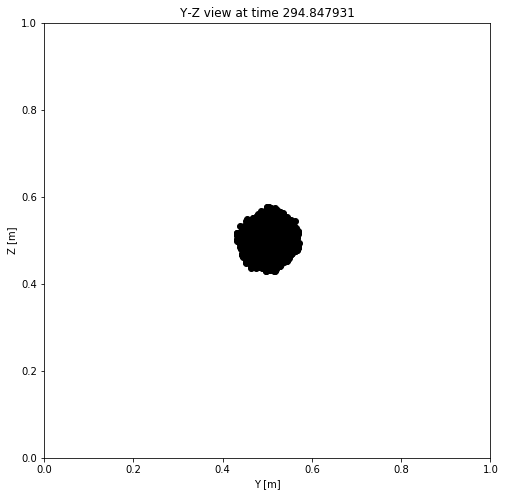

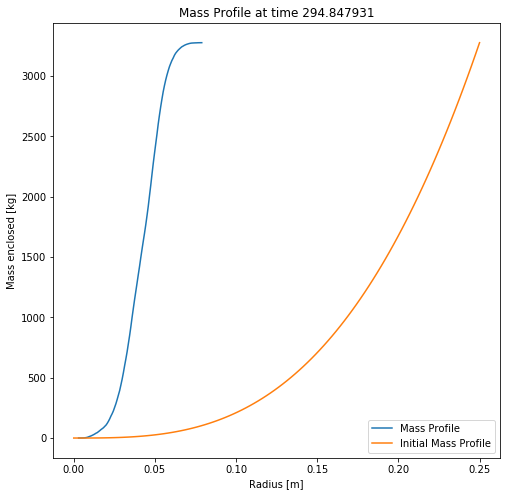

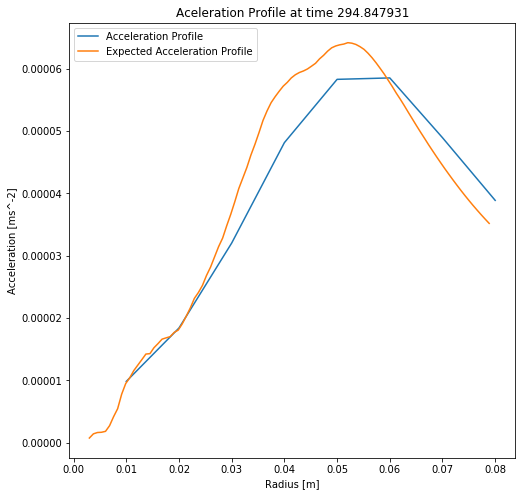

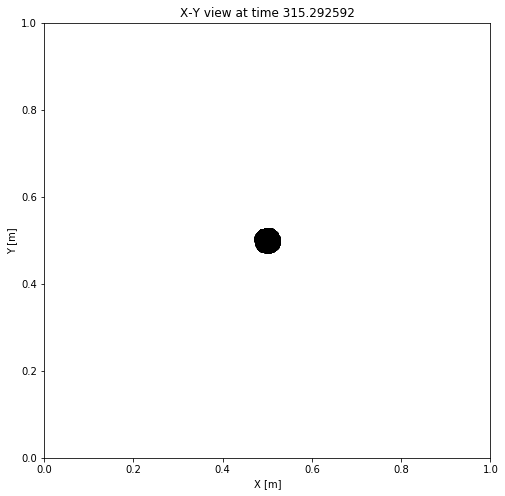

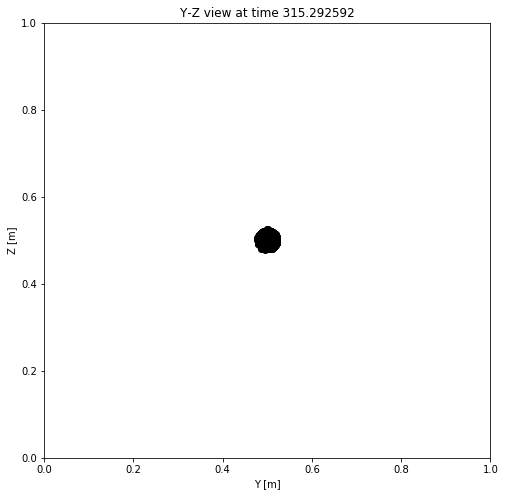

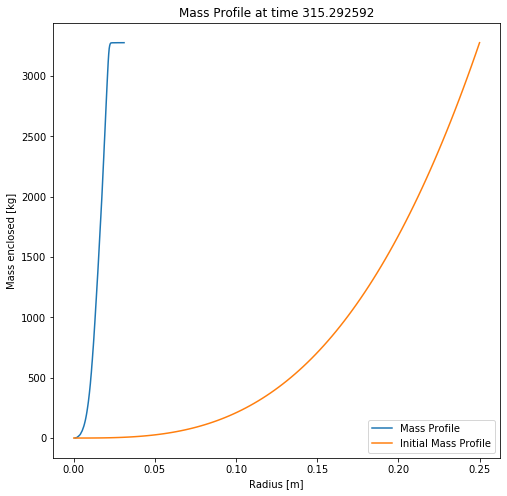

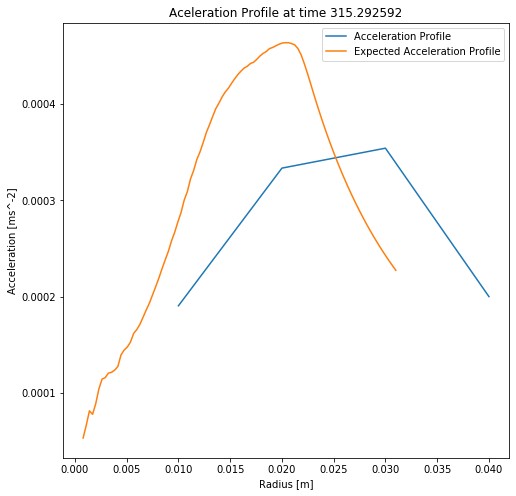

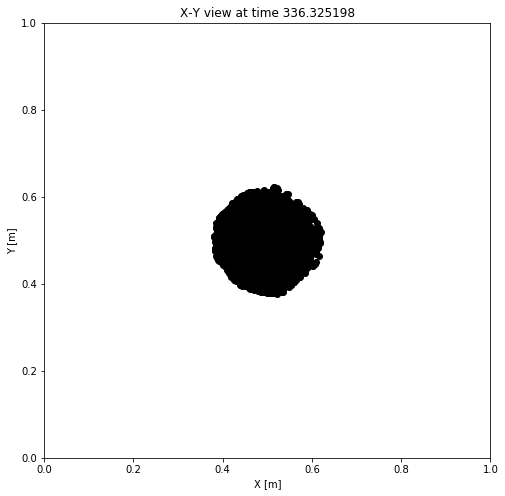

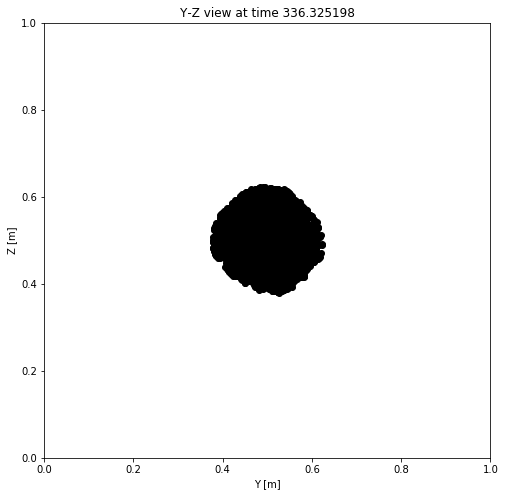

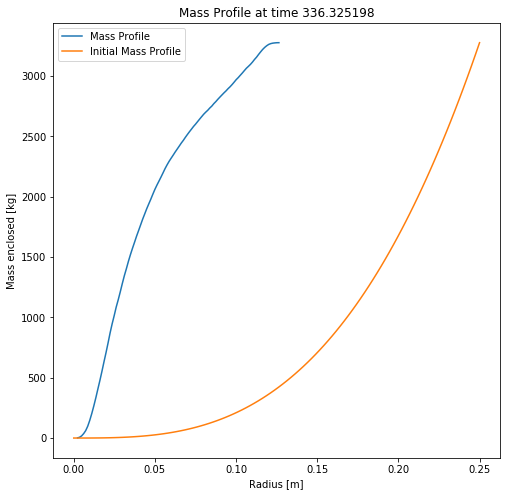

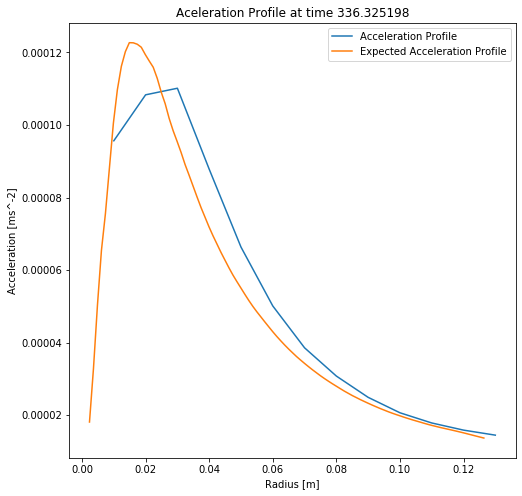

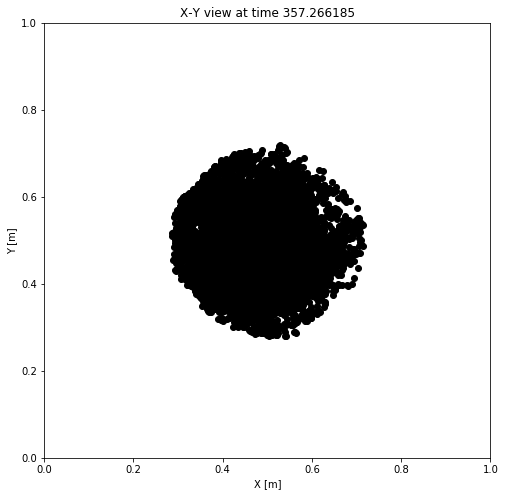

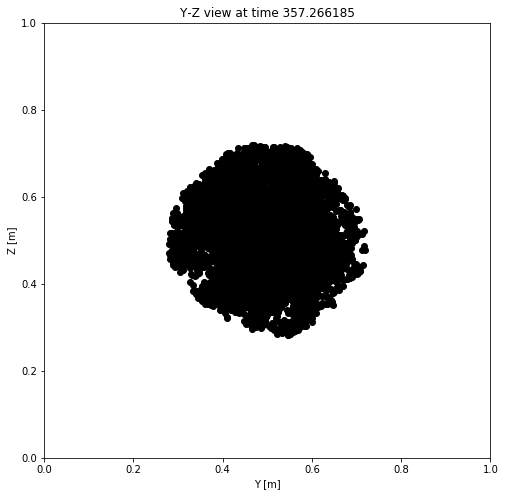

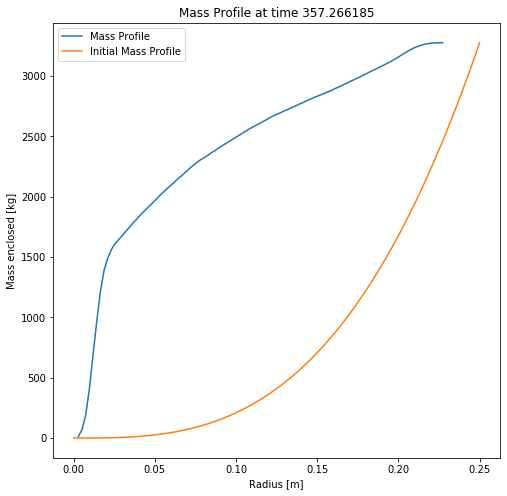

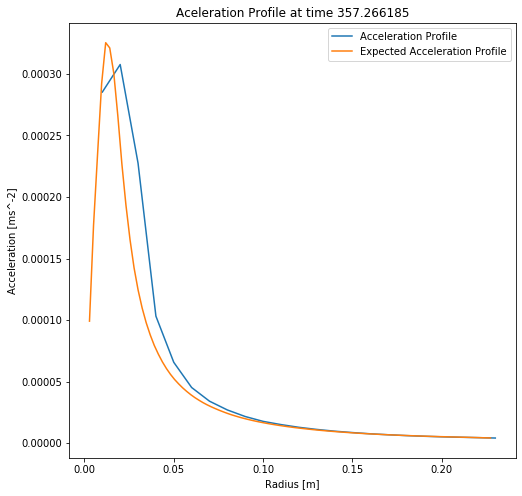

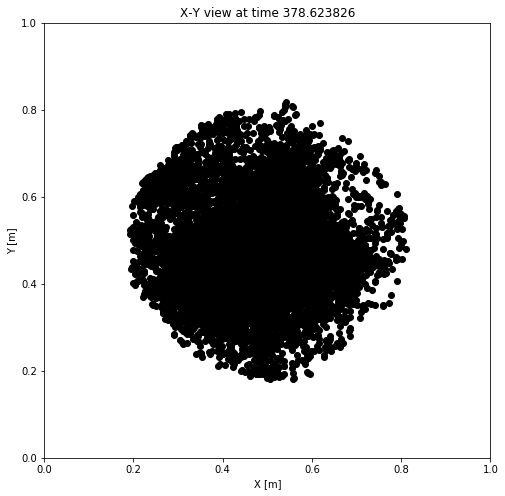

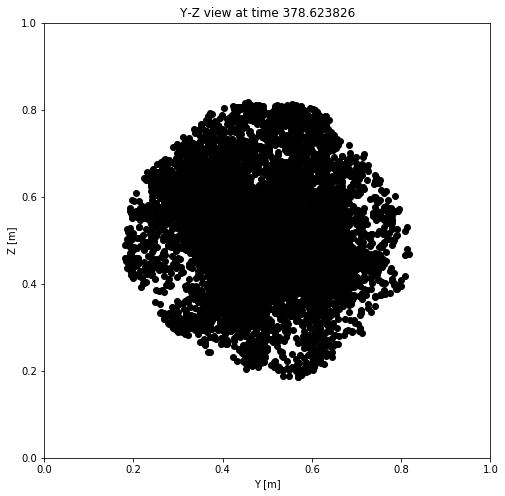

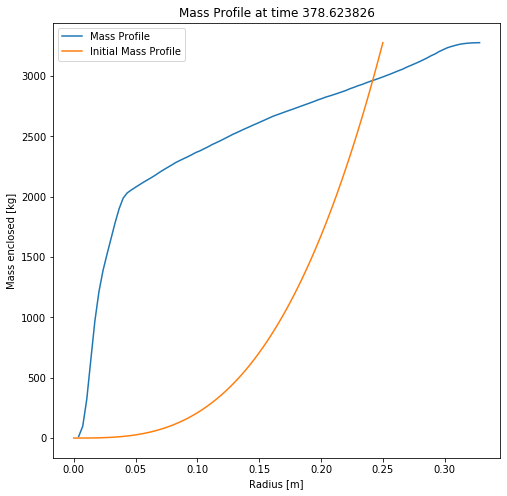

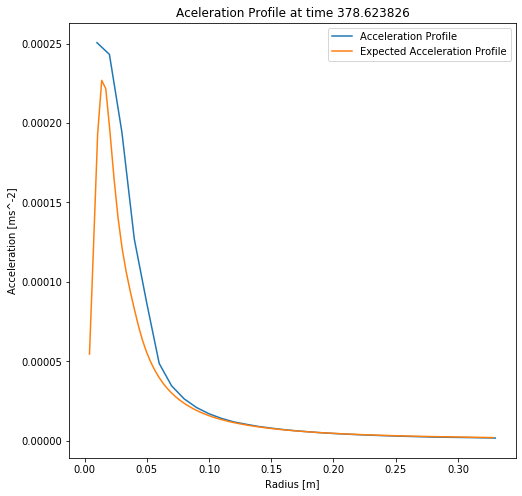

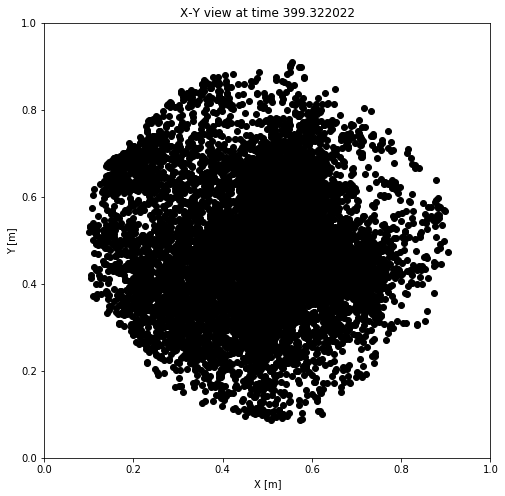

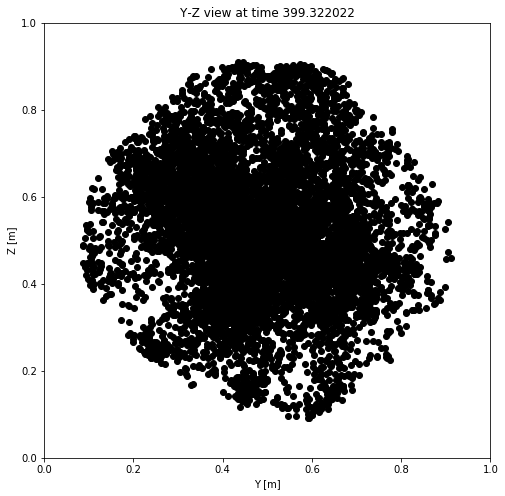

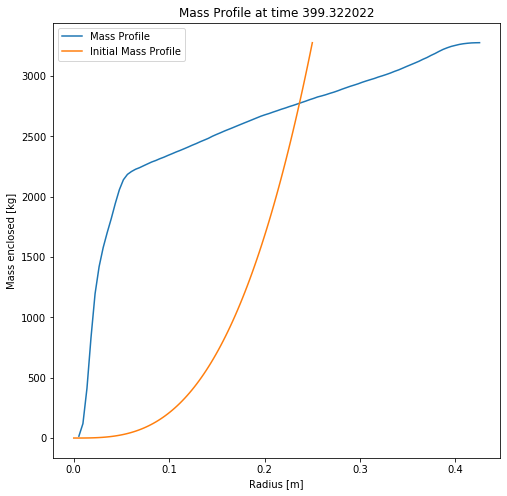

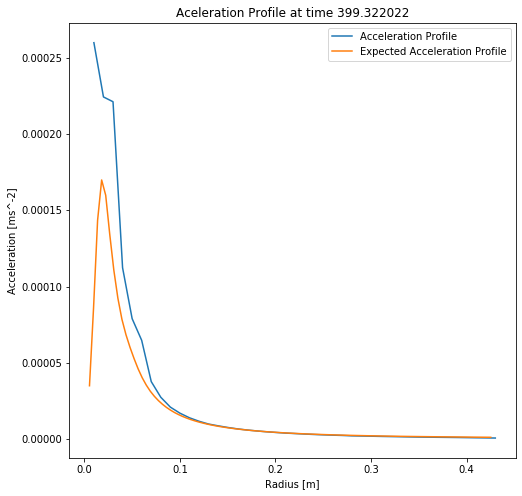

array([[ 6.70175321e-01,  5.11043496e-01,  6.69624945e-01, ...,
        -2.05595003e-06, -5.21067844e-08, -2.04083658e-06],
       [ 4.97577454e-01,  5.03206151e-01,  4.90904466e-01, ...,
         1.99772150e-04,  1.88632096e-04,  3.10434124e-05],
       [ 4.69045729e-01,  6.82234973e-01,  4.26971160e-01, ...,
         9.66845886e-07, -4.21010440e-06,  1.58113639e-06],
       ...,
       [ 5.10271590e-01,  4.99112118e-01,  4.97746452e-01, ...,
        -1.29158349e-05,  2.58077666e-04, -6.15666916e-05],
       [ 5.42008723e-01,  6.57222126e-01,  5.64104830e-01, ...,
        -9.97396984e-07, -5.17014248e-06, -2.24053564e-06],
       [ 5.25898121e-01,  6.94660412e-01,  7.81132487e-01, ...,
         2.05183560e-08, -7.75287548e-07, -9.96668061e-07]])

In [20]:
master()

# Discussion of Results

We'll start off by discussing the one-particle test. In the middle of the graph, in a range of roughly 0.01 to 0.2 meters, force lines up very well with our prediction. However, we see force drops off as distance approaches zero. This is due to one of the limitations of the particle-mesh method. For the same reason that, in this simulation, a particle will not induce a force on itself, two particles in the same cell will have much smaller forces on each other than expected. In the case where they occupy the exact same point, they will have no force on each other. This is what leads to the drop off on the one particle force test towards very small values of r.

We also see drop off towards larger values of r. This is due to the fact that we take a fourier transform of the density field. As a result, the density field is presumed to be periodic, so a point close to the edge of the border sees an exact copy of our simulation at the other side. This means that when we're looking at the force from one particle at a cell near the border, that cell really feels the force from two systems; one is the one that we're modeling, and the other is a copy of it in the other direction, because we took a fourier transform. As a result, the net force will be smaller for cells close to the border, which is why we have a drop off for high values of r.

In essence, these two inconsistencies that we see from the one particle force test result in the inconsistencies we see in the simulation.

The particle mesh method and our fourier transform are what create differences between the simulation and our expectations, because they sacrifice some accuracy for much greater speed. This is reflected in the difference in run time between particle mesh and particle particle methods; particle mesh is only O(N log N) while particle particle is O(N^2).

Our system behaves well for approximately 300-320 seconds, continuing to get smaller and smaller in size. This is what we expect, given that this is a gravitational collapse. However, we quickly see the sphere expand until it reaches the boundaries of our simulation. This is inconsistent with what theory predicts.

This expansion is a result of the particle mesh method. As mentioned earlier, particles in the same cell will feel a reduced force towards each other. So, as the sphere gets smaller and smaller, and the particles get closer and closer, the attraction they feel towards other, nearby particles are smaller than they should be. So where the particles should stick together, they end up not feeling as much attraction to each other and continuing on their respective velocities until they hit the edge of the simulation.

So we see that there is a resolution limit on the particle mesh method. If two particles are within a cell's distance of each other, they will feel too little force. And there is a cap on size as well; if two particles are too far apart, then the forces coming from the periodic copies of the simulation past the simulation boundary will result in differences from what we expect.

# Independent Work: Spinning Disk

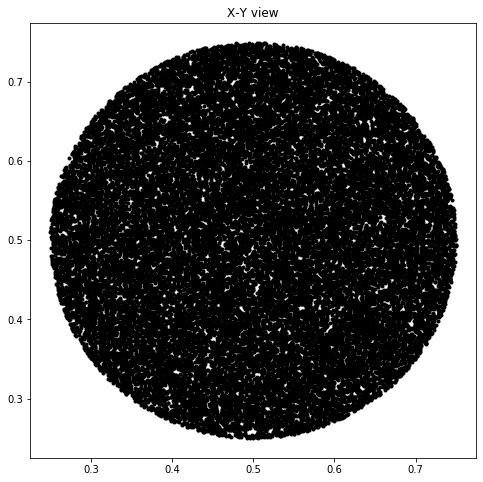

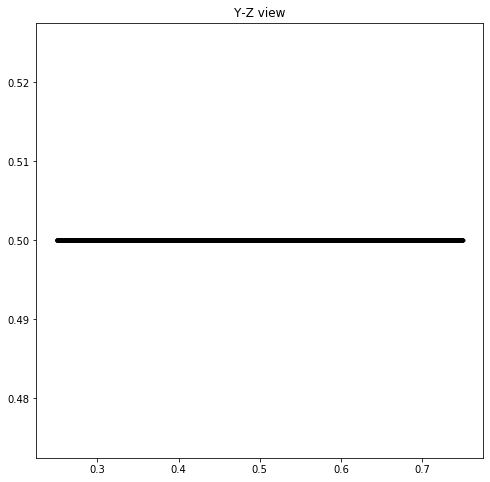

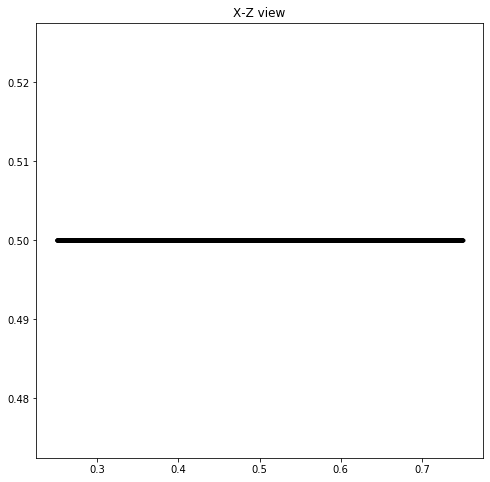

In [11]:
def generateDisk():
    
    omega = 0.0005
    
    result = np.zeros((Np, 9))
    #x y z vx vy vz ax ay az
    cylCoords = np.random.rand(Np,2)
    
    #set 0 <= radius <= 1/4 Meters
    #Transforming uniform distribution to desired distribution for radius
    cylCoords[:,0] *= 2
    cylCoords[:,0] = cylCoords[:,0]**(1/2)
    cylCoords[:,0] *= 0.25/(np.sqrt(2))
    
    
    #set 0 <= phi <= 2*pi
    cylCoords[:,1] *= 2*pi
    
    
    
    #Transforming from cylindrical to cartesian
    
    xs = cylCoords[:,0]*cos(cylCoords[:,1])
    xs = xs + 0.5
    ys = cylCoords[:,0]*sin(cylCoords[:,1])
    ys = ys + 0.5
    zs = 0.5
    vx = -cylCoords[:,0]*omega*sin(cylCoords[:,1])
    vy = cylCoords[:,0]*omega*cos(cylCoords[:,1])
    result[:,0] = xs
    result[:,1] = ys
    result[:,2] = zs
    result[:,3] = vx
    result[:,4] = vy
    return result

part = generateDisk()

plt.figure(figsize=(8,8))
plt.title("X-Y view")
plt.plot(part[:,0],part[:,1], "k.")
plt.show()

plt.figure(figsize=(8,8))
plt.title("Y-Z view")
plt.plot(part[:,1],part[:,2], "k.")
plt.show()

plt.figure(figsize=(8,8))
plt.title("X-Z view")
plt.plot(part[:,0],part[:,2], "k.")
plt.show()

In [12]:
def cylDisplayResults(part, t):
    plt.figure(figsize=(8,8))
    plt.title("X-Y view at time %f" %t)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot(part[:,0],part[:,1], "ko")
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.show()

    plt.figure(figsize=(8,8))
    plt.title("Y-Z view at time %f" %t)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot(part[:,1],part[:,2], "ko")
    plt.xlabel("Y [m]")
    plt.ylabel("Z [m]")
    plt.show()
    
    mP, mPRs = massProfile(part)
    rs = np.linspace(0,0.25,100)
    ys = Np*m*(rs/0.25)**2
    
    plt.figure(figsize=(8,8))
    plt.title("Mass Profile at time %f" %t)
    plt.ylabel("Mass enclosed [kg]")
    plt.xlabel("Radius [m]")
    plt.plot(mPRs, mP, label="Mass Profile")
    plt.plot(rs, ys, label="Initial Mass Profile")
    plt.legend()
    plt.show()

    aProfile, aRs = accelerationProfile(part)
    aExpected, aExpectedRs = expectedAccelerationProfile(mP, mPRs)

    plt.figure(figsize=(8,8))
    plt.title("Aceleration Profile at time %f" %t)
    plt.plot(aRs, aProfile, label="Acceleration Profile")
    plt.plot(aExpectedRs, aExpected, label="Expected Acceleration Profile")
    plt.ylabel("Acceleration [ms^-2]")
    plt.xlabel("Radius [m]")
    plt.legend()
    plt.show()
    


In [17]:
def cylMaster():
    #set initial conditions
    part = generateDisk()
    density = CIC(part)
    potential = getPotential(density)
    part[:,6:] = acceleration(potential, part)
    t = 0
    
    tDyn = np.sqrt((pi**2)*(0.25**3)/(4*G*Np*m))
    mult = -1
    
    while t < tDyn:
        if t // 21 > mult:
            cylDisplayResults(part, t)
            mult = t // 21
        deltaT = timeStep(part)
        part = verlet(part, deltaT)
        
        
        t += deltaT
        
    return part

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


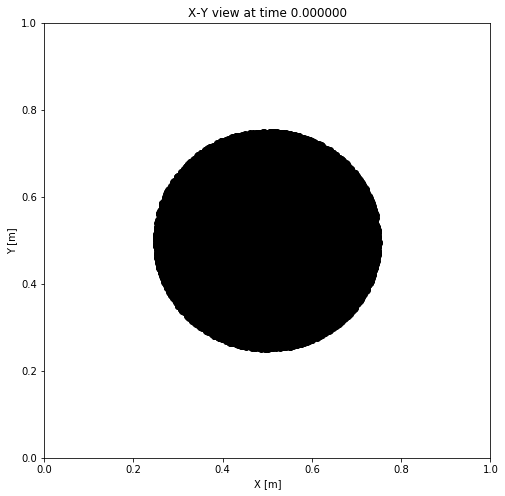

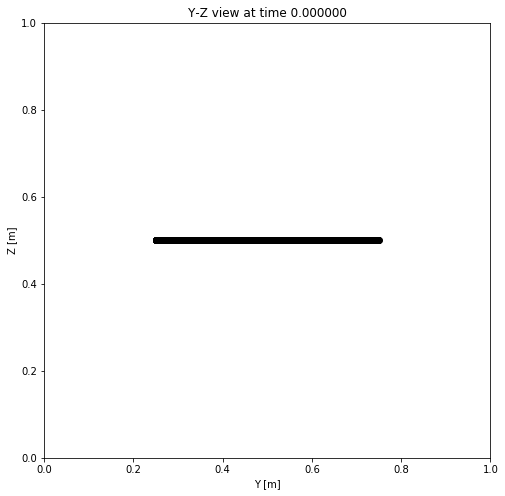

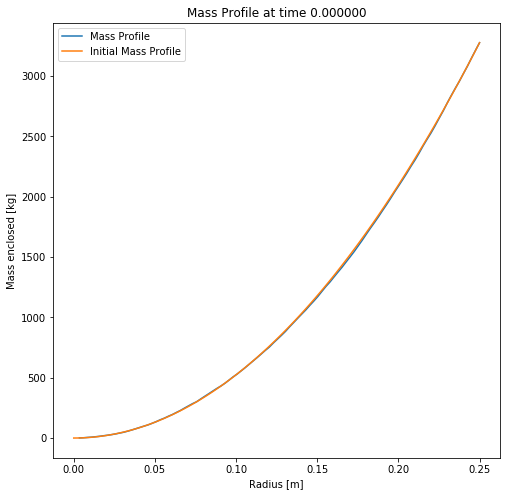

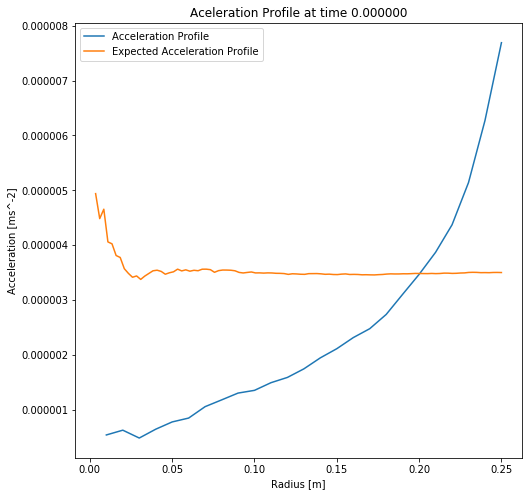

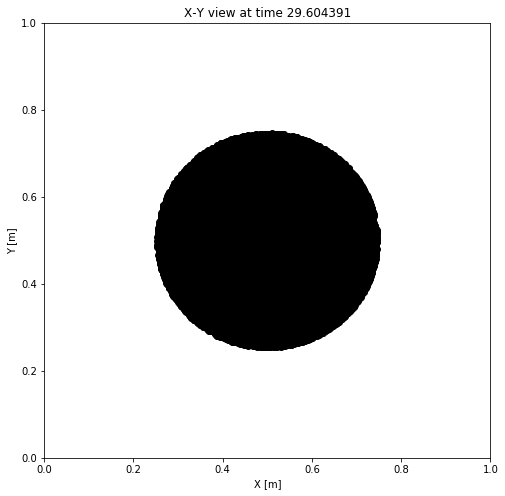

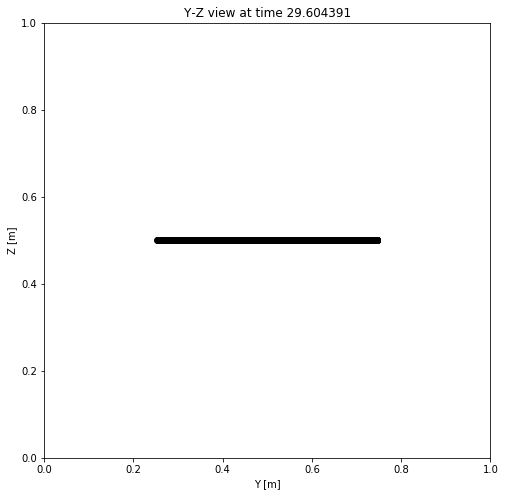

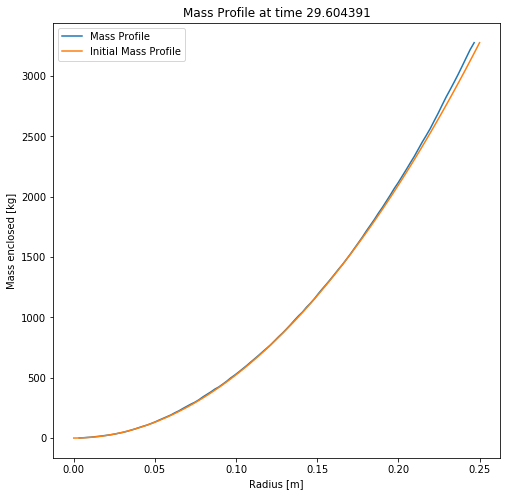

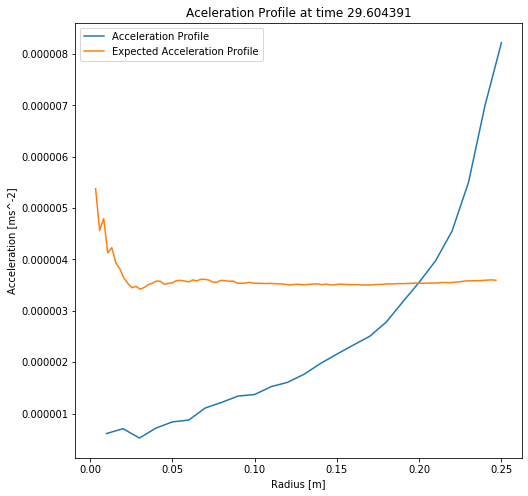

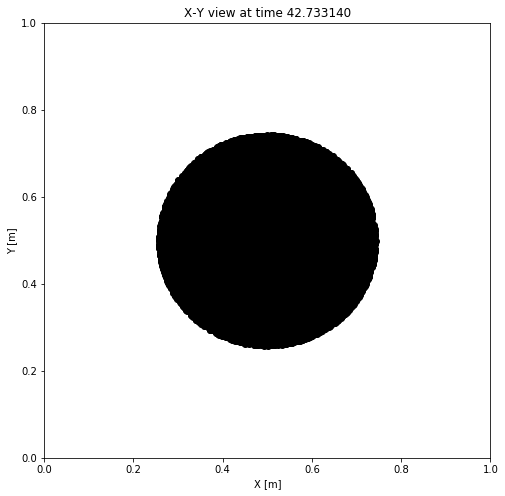

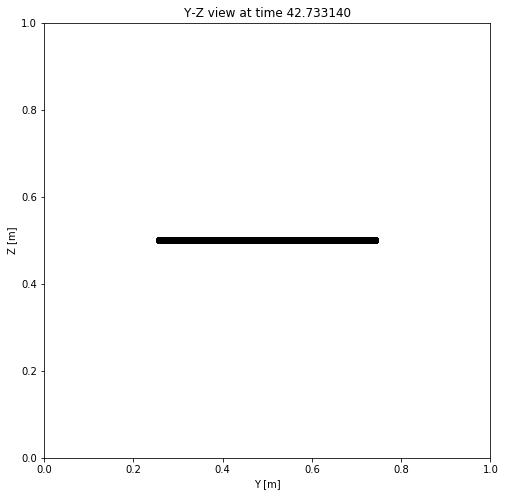

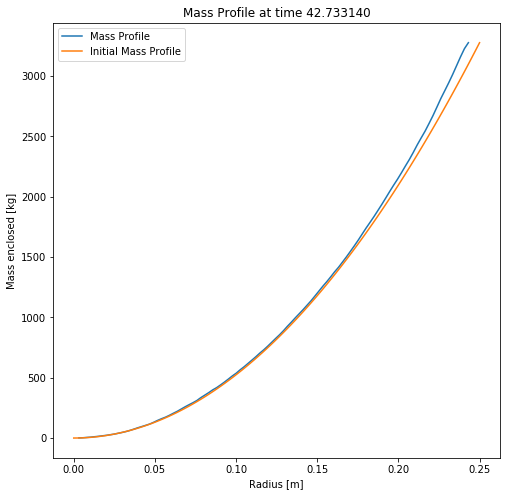

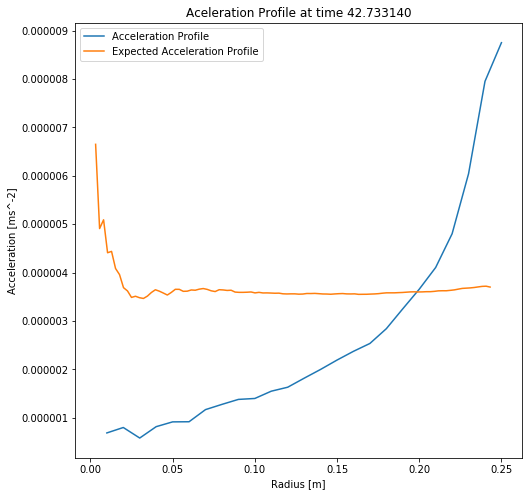

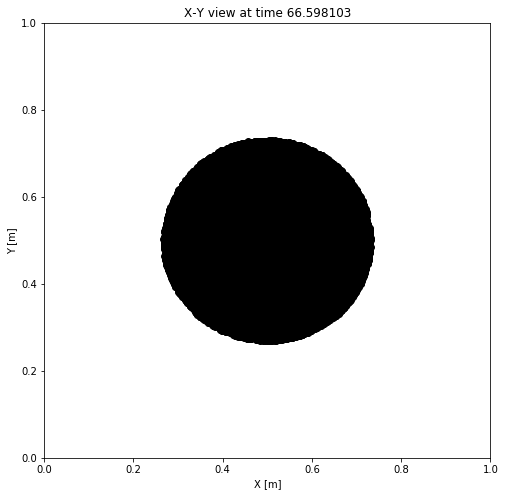

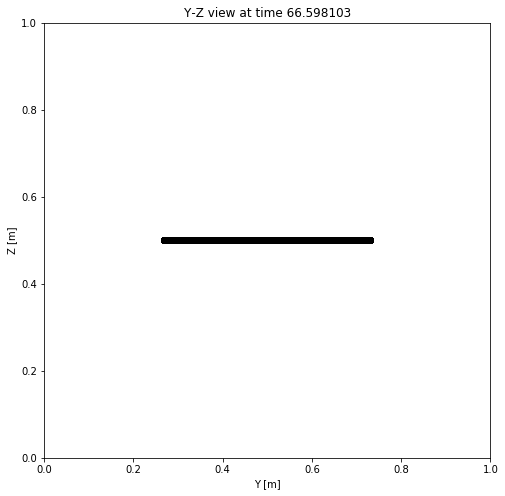

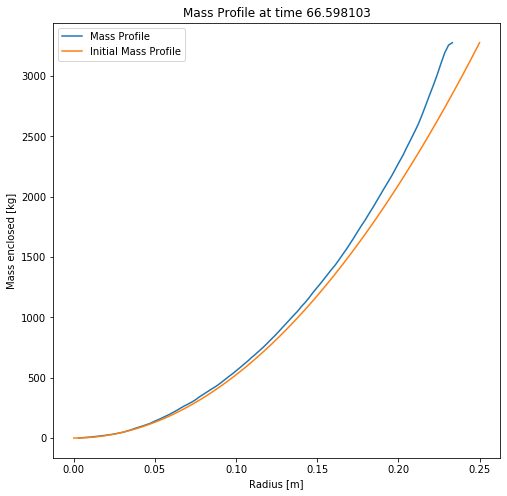

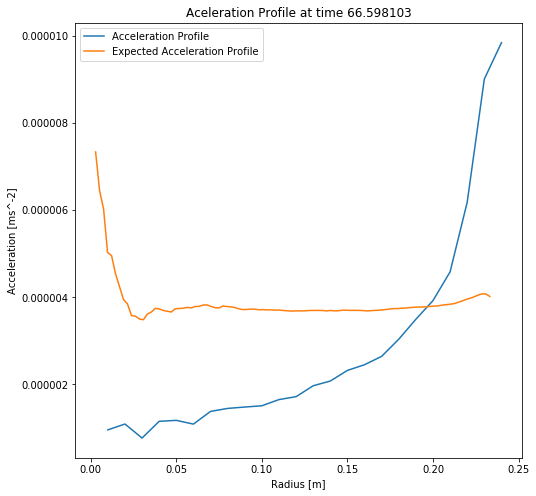

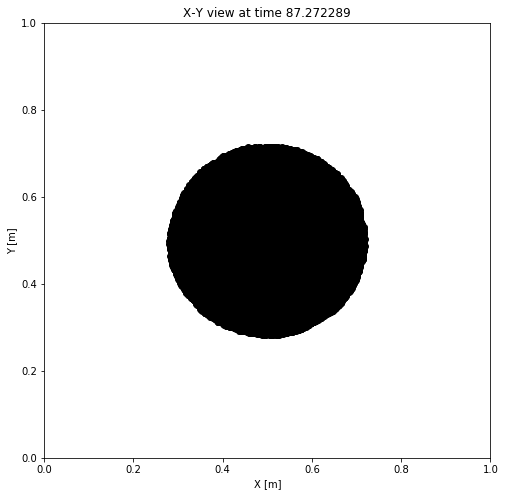

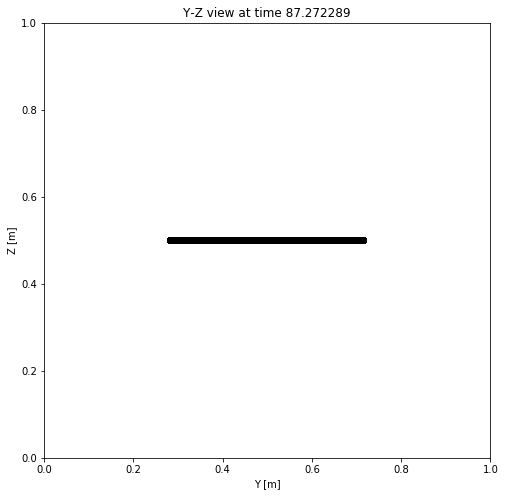

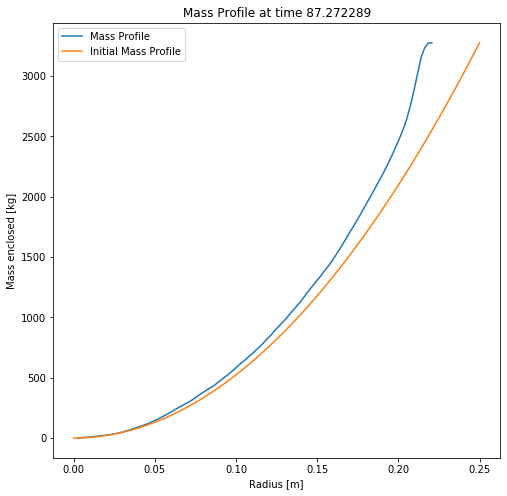

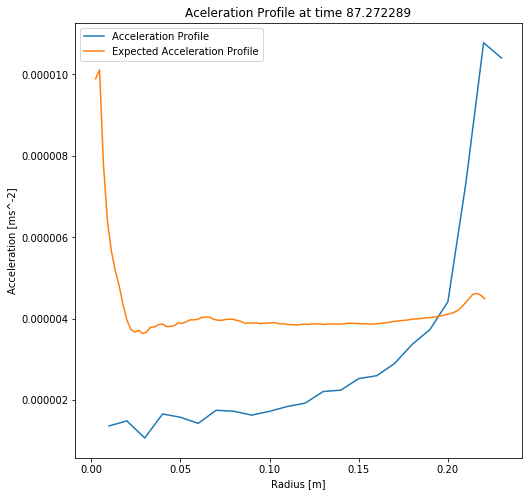

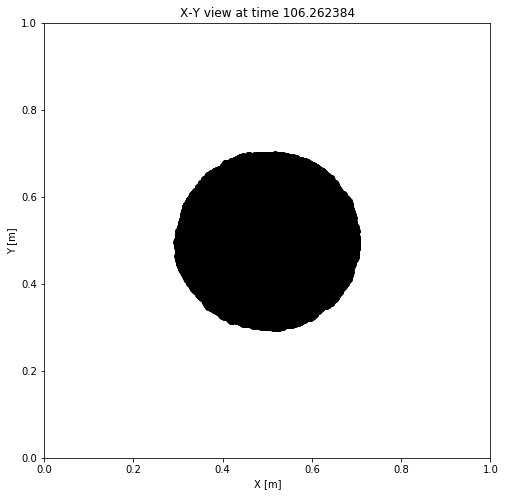

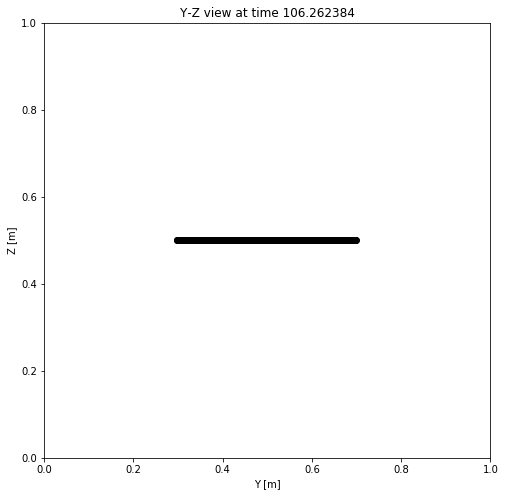

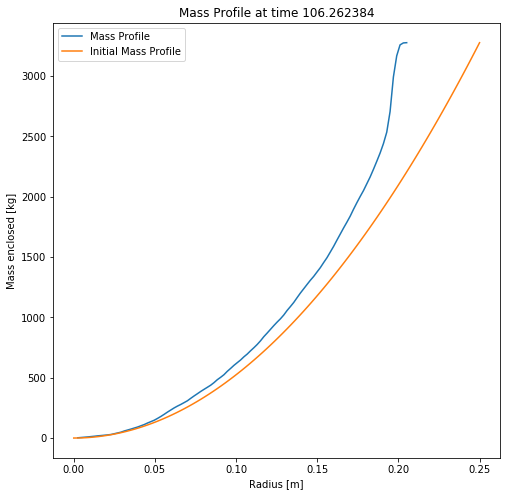

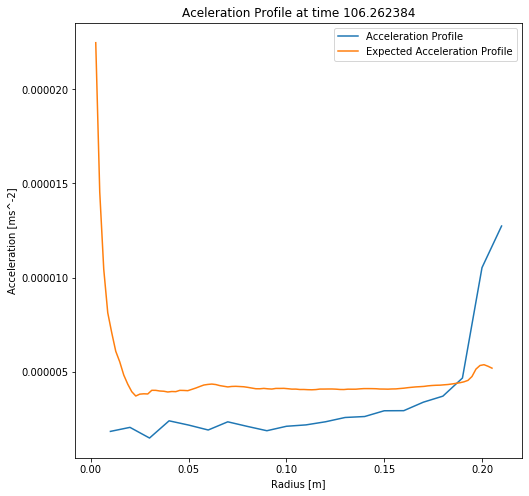

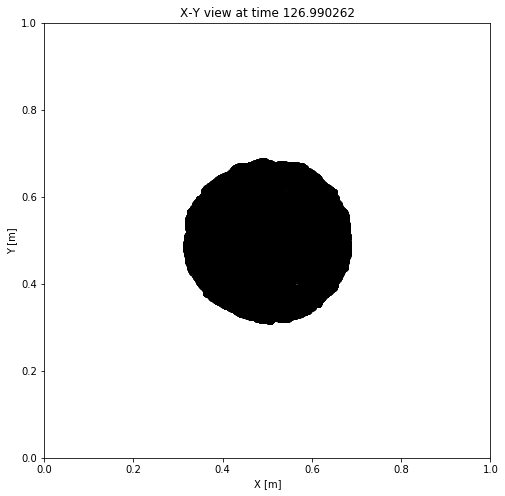

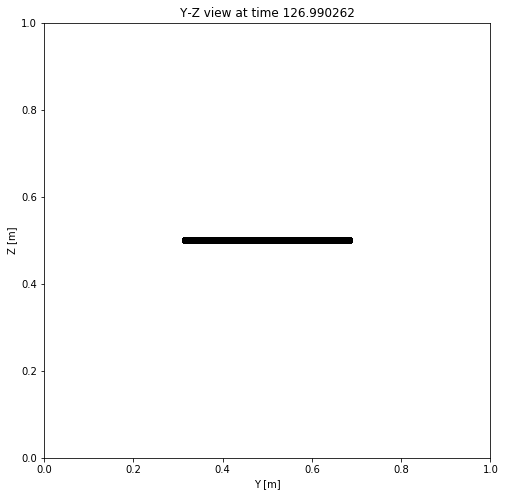

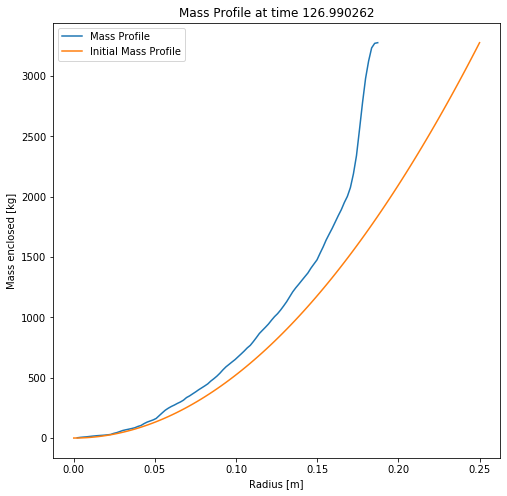

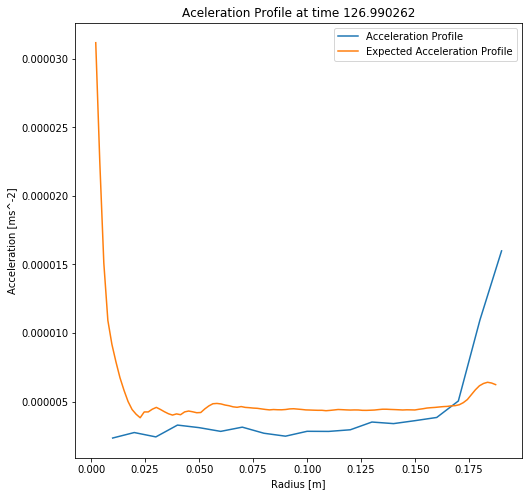

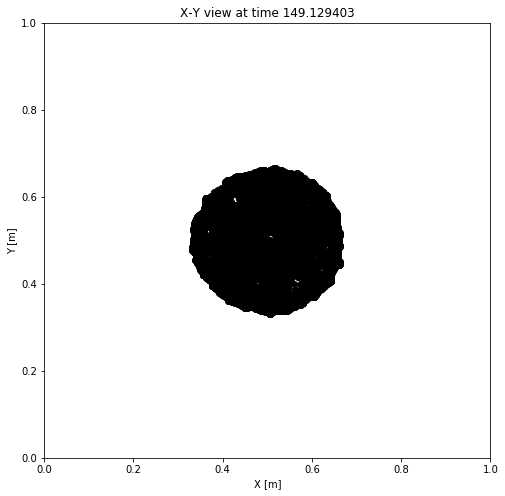

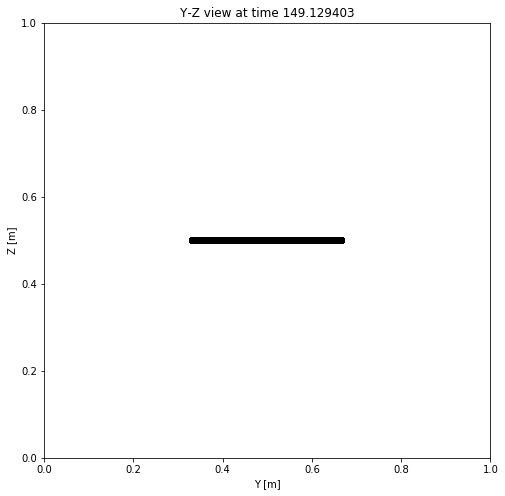

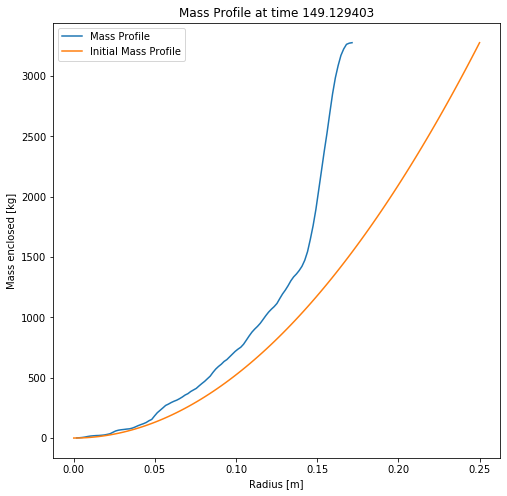

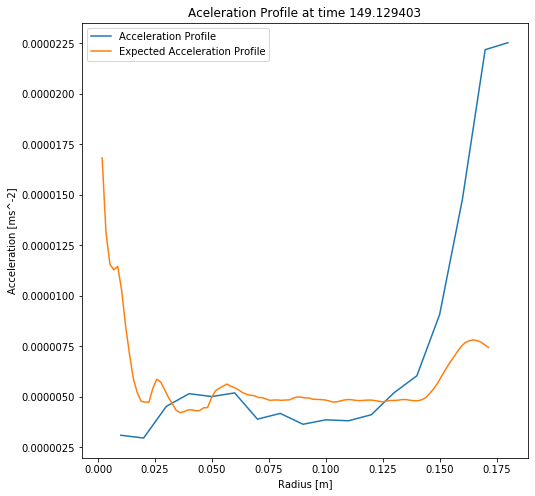

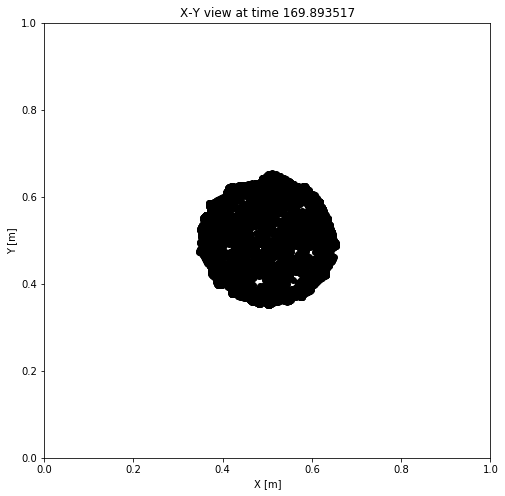

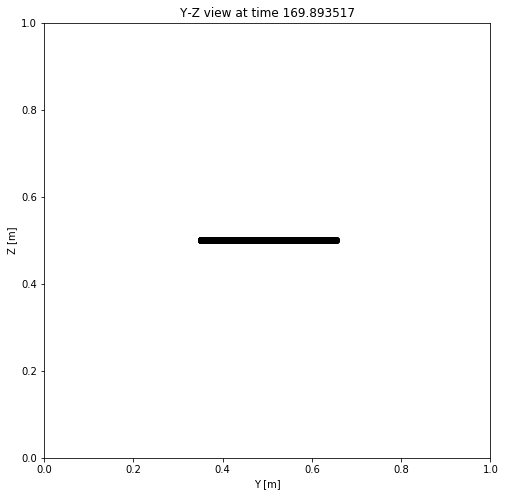

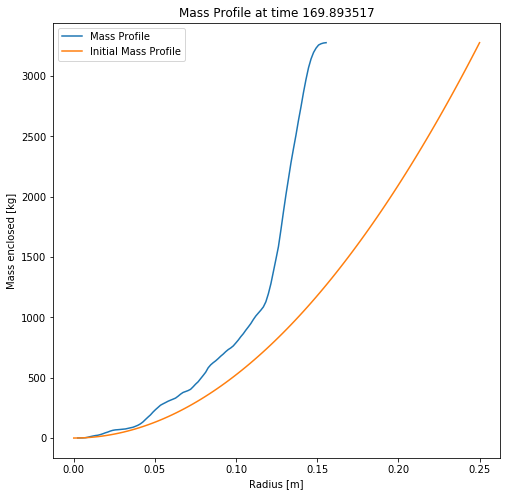

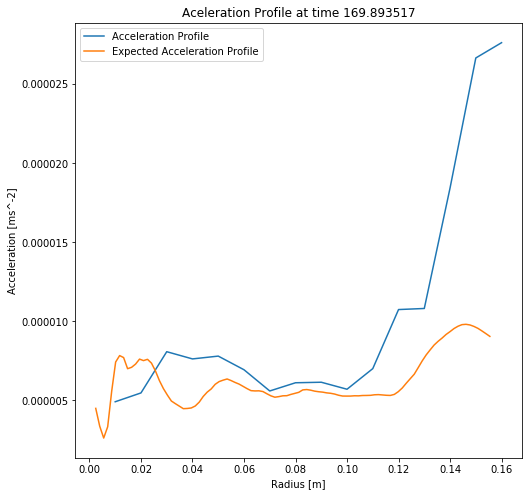

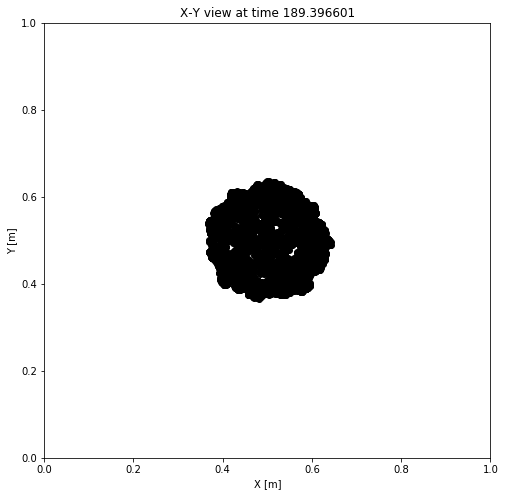

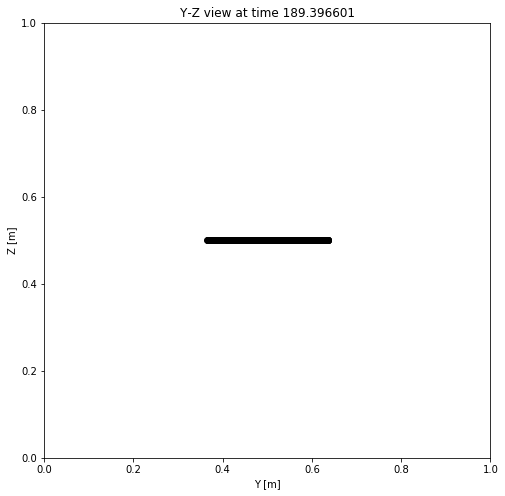

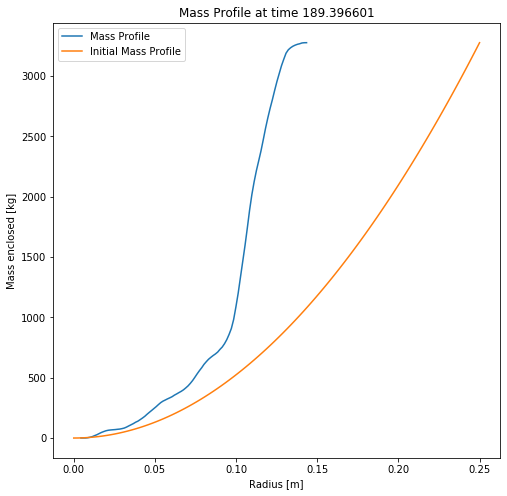

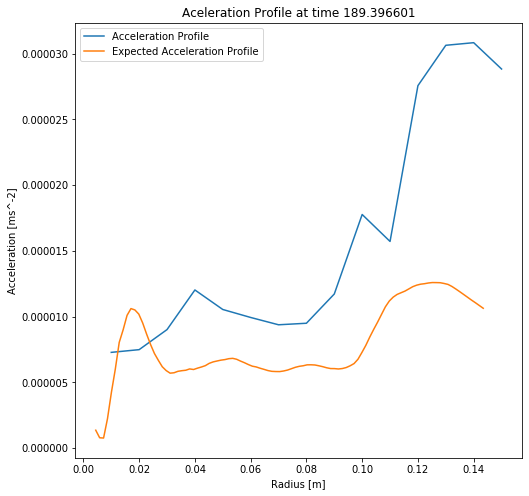

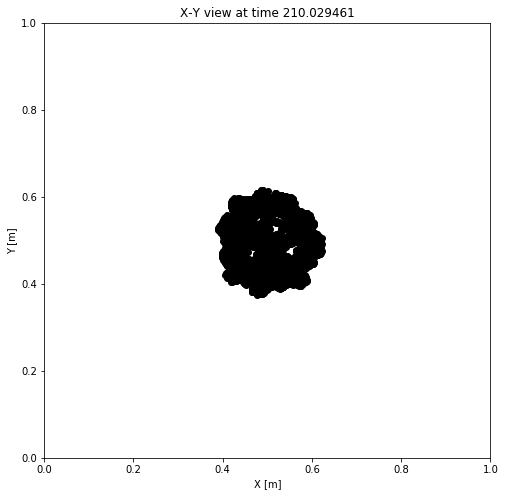

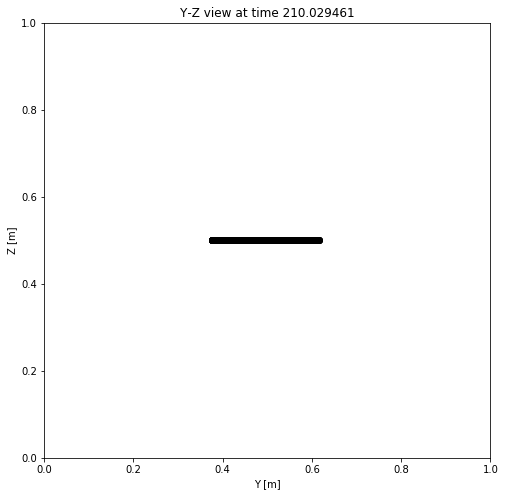

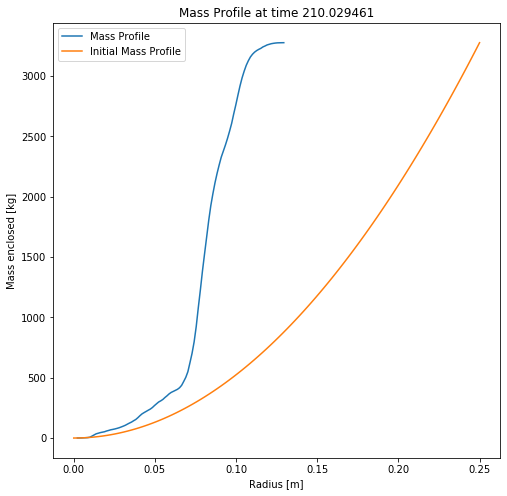

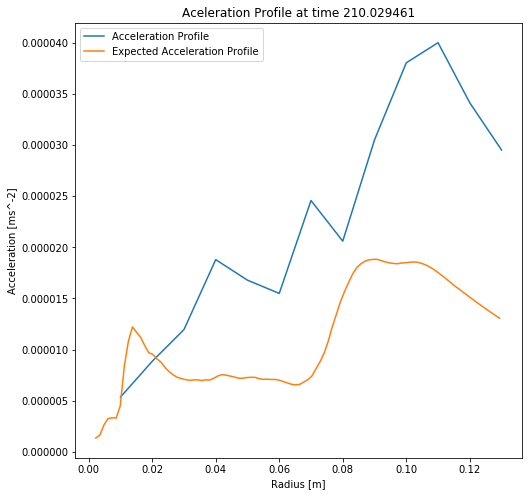

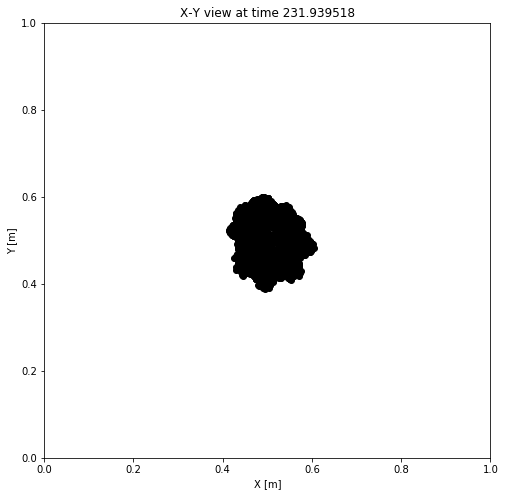

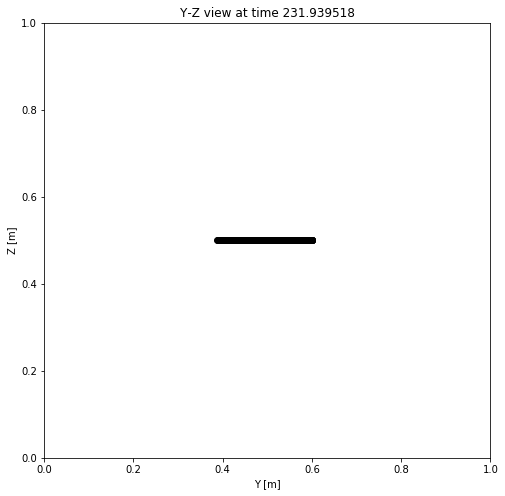

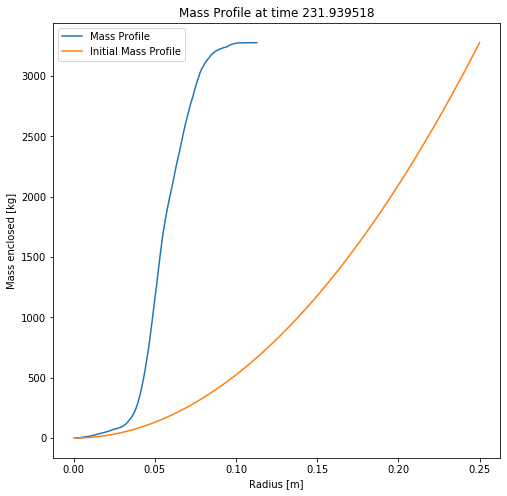

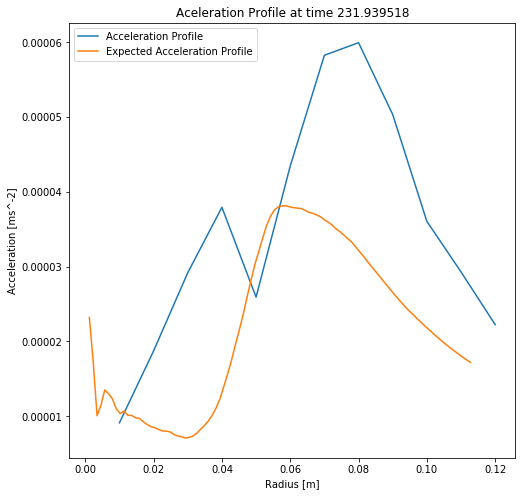

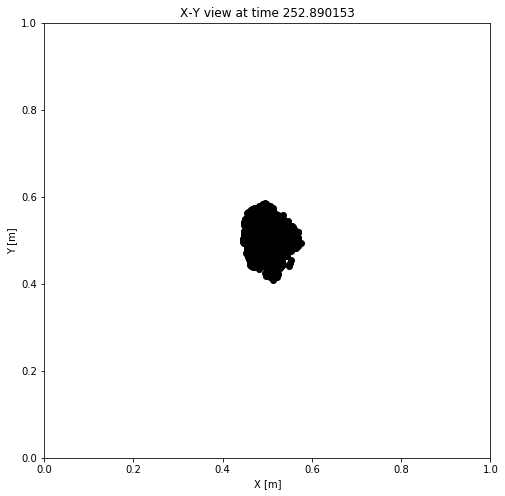

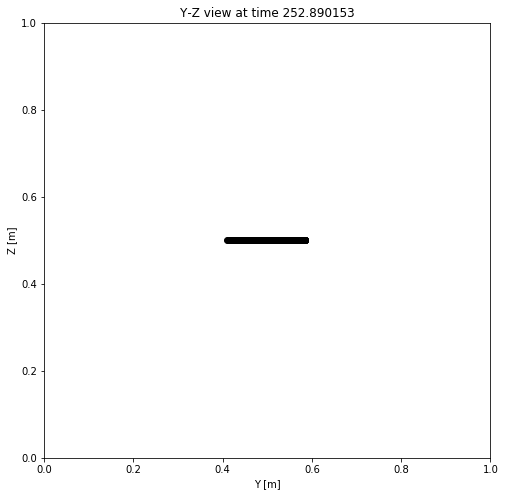

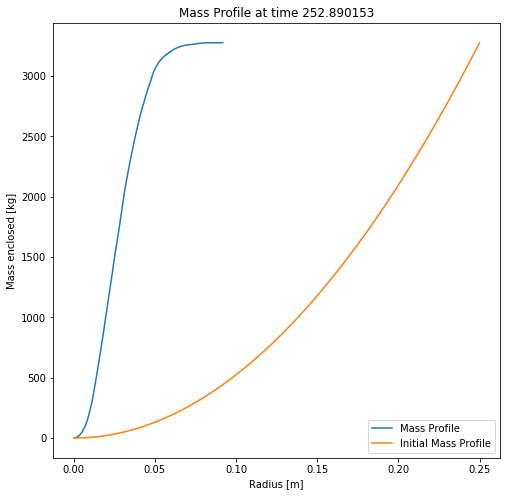

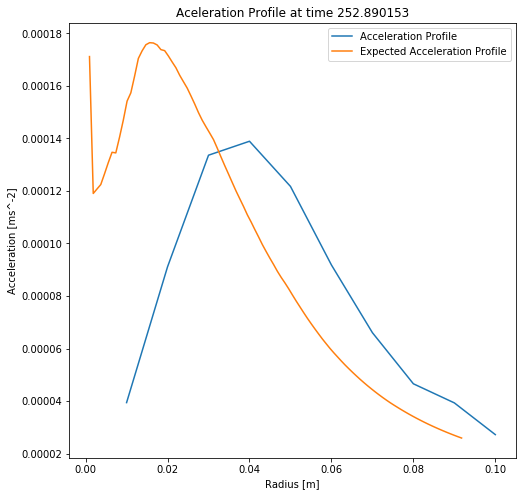

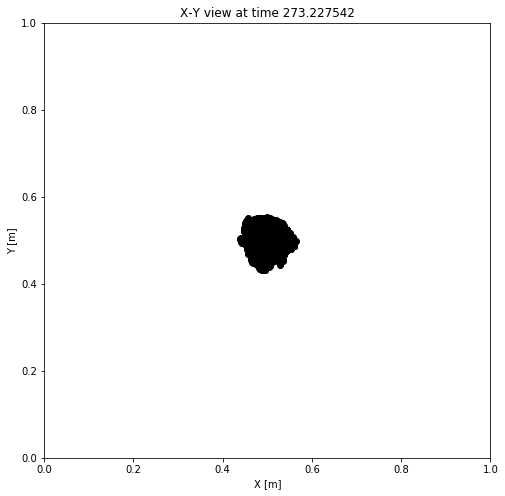

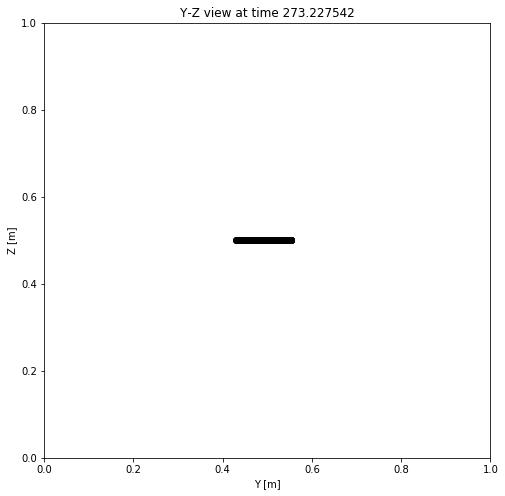

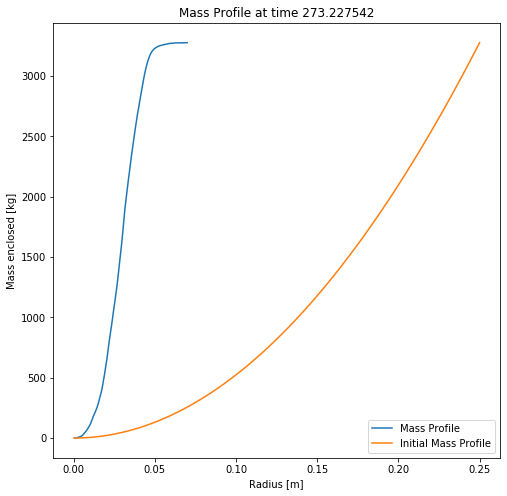

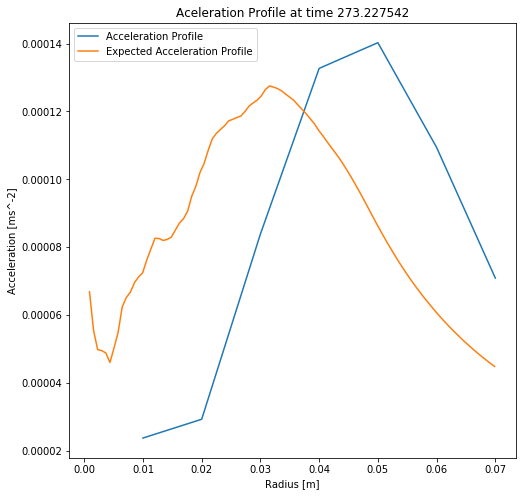

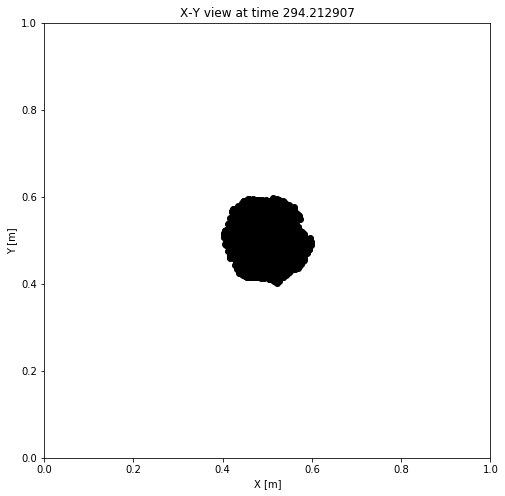

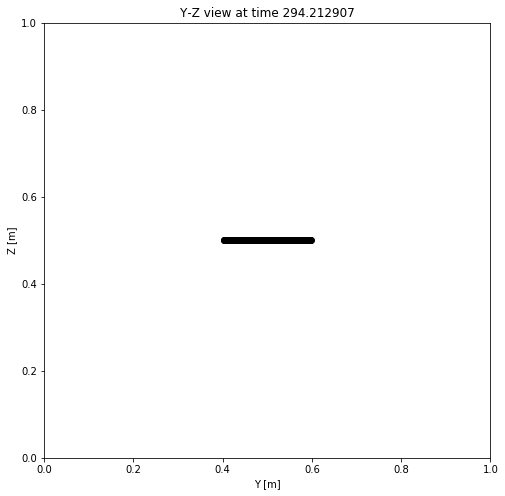

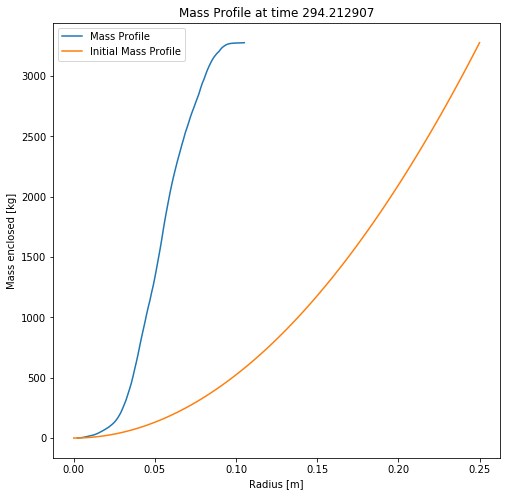

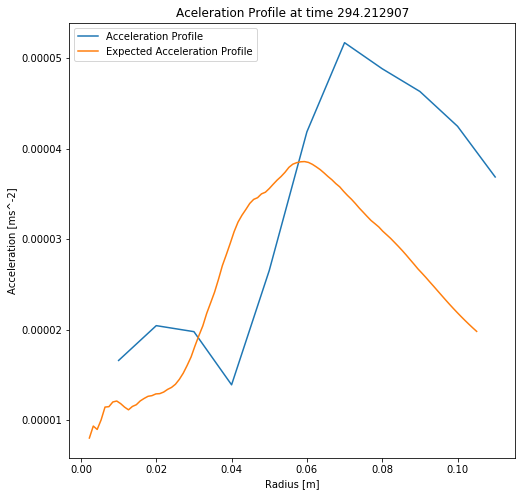

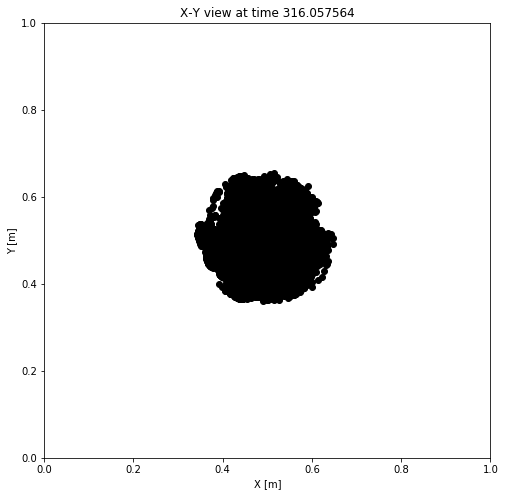

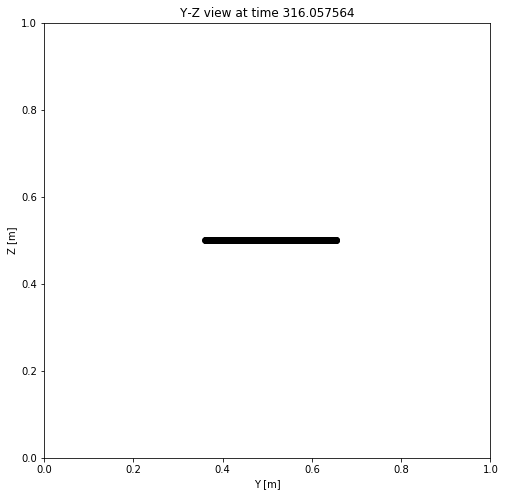

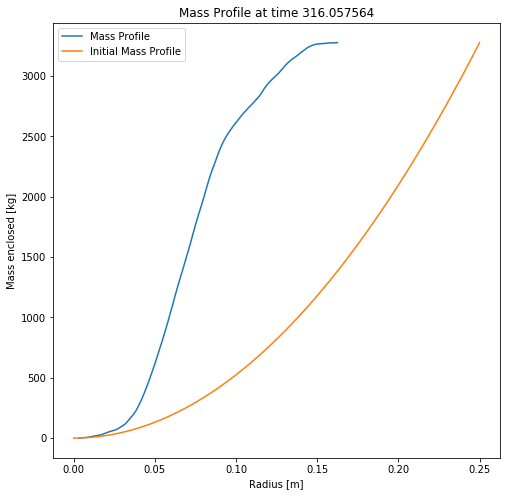

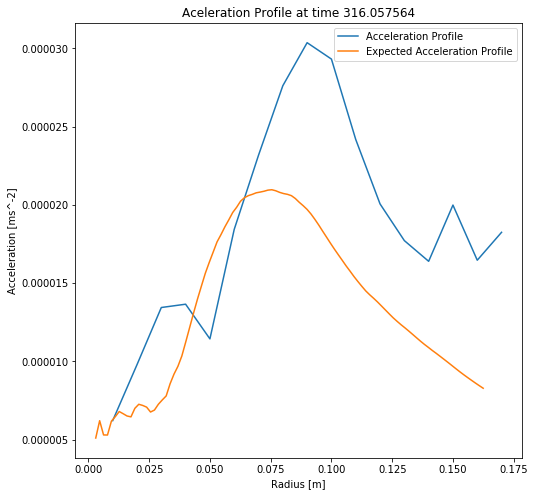

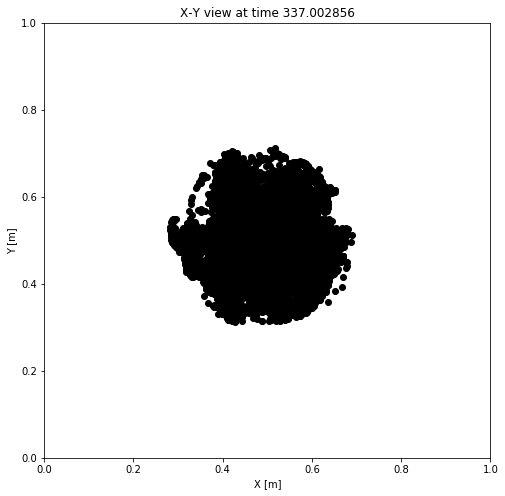

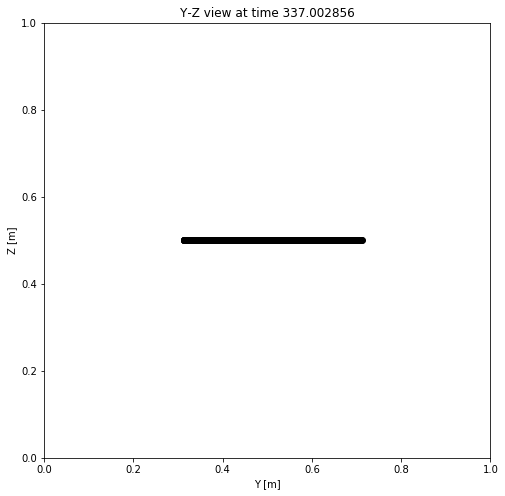

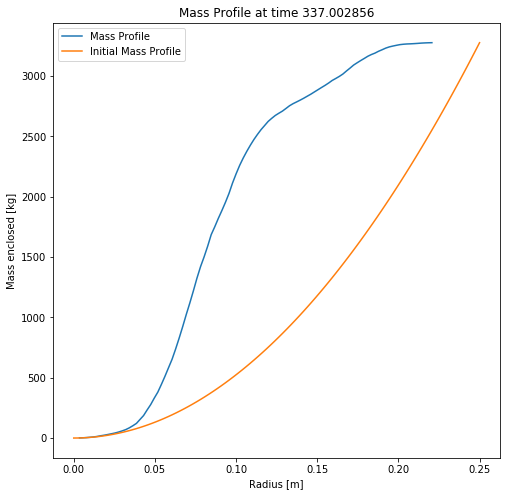

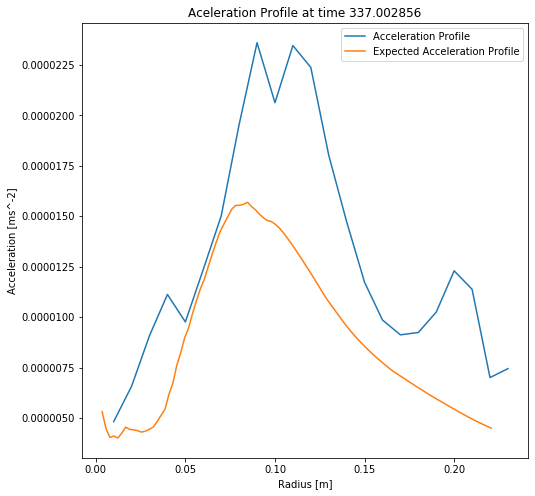

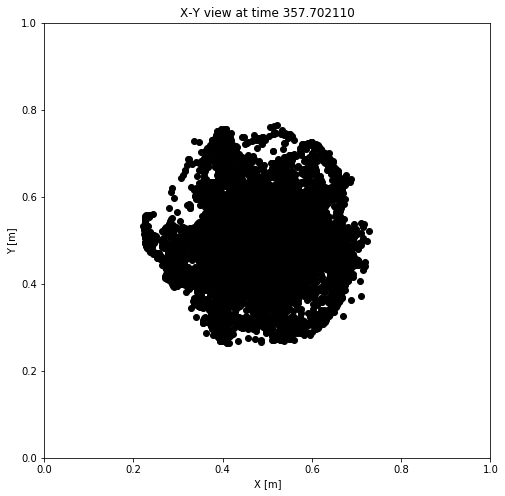

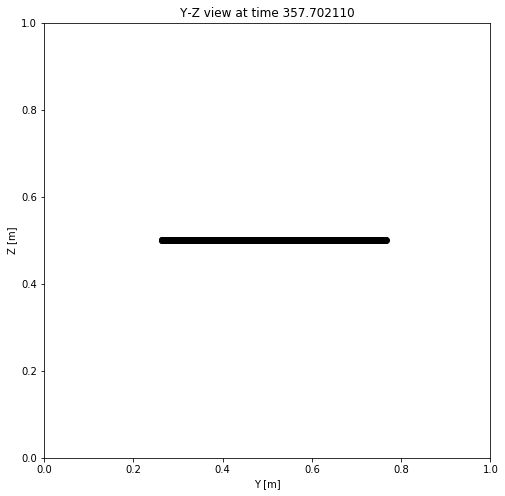

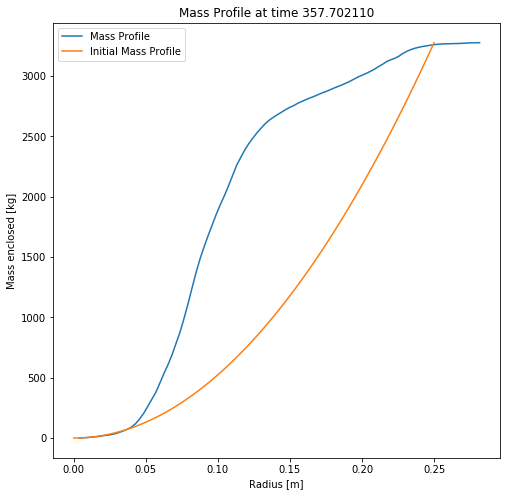

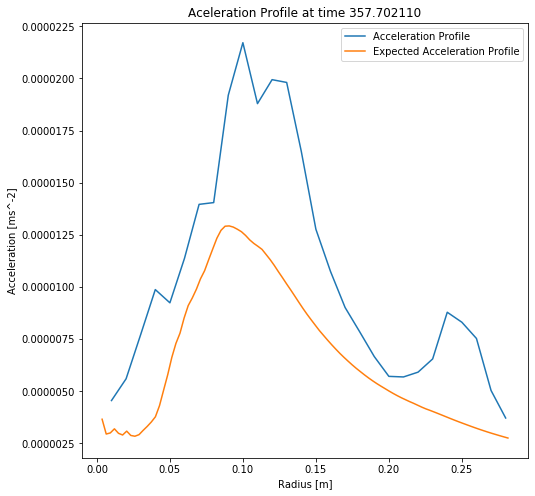

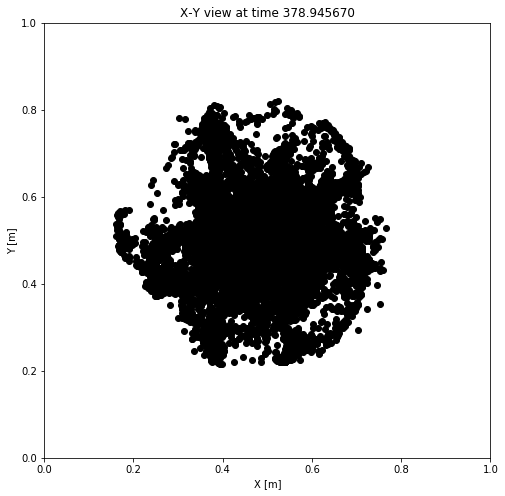

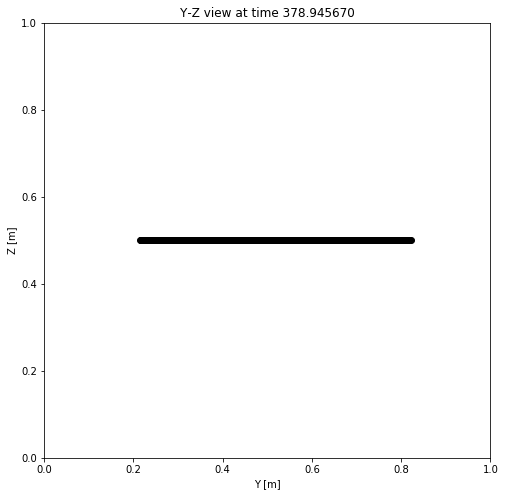

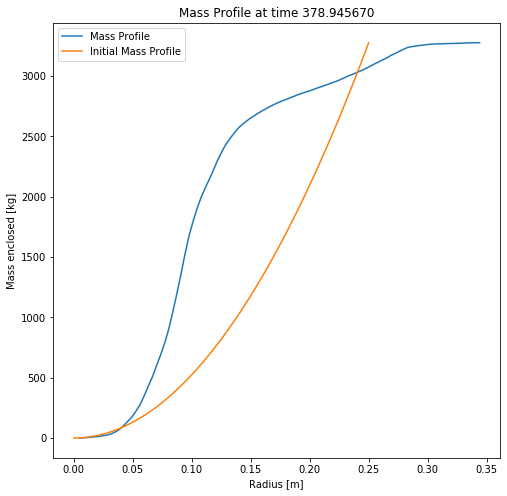

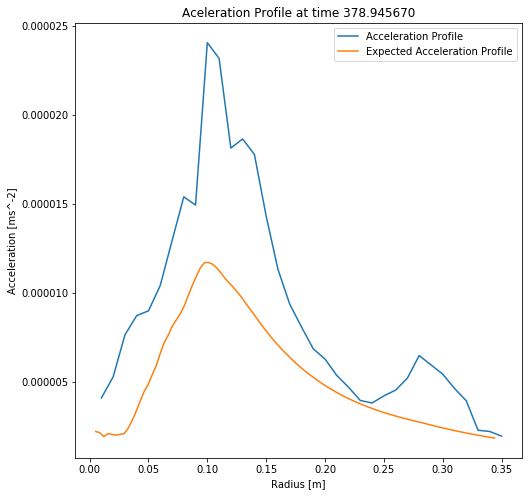

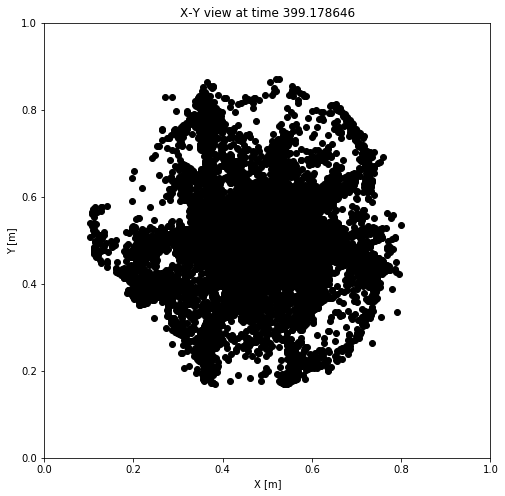

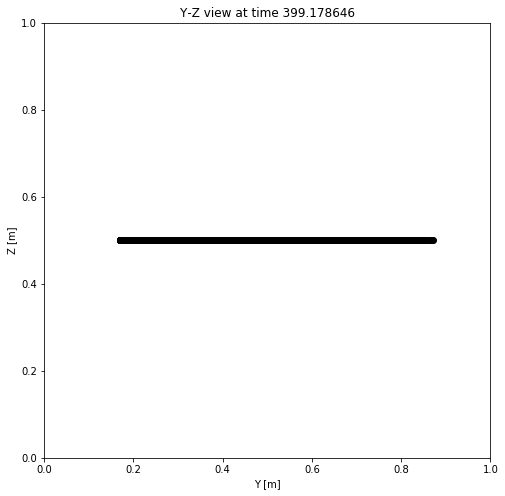

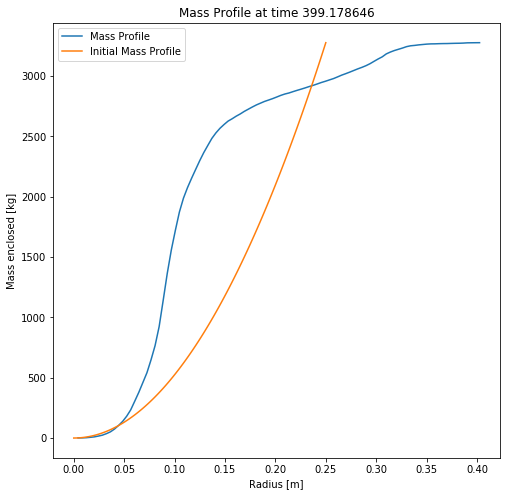

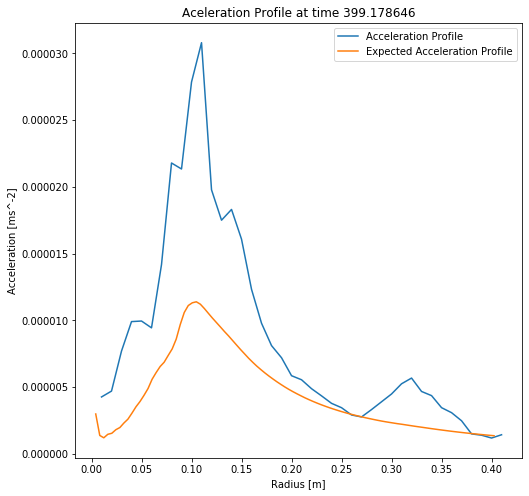

array([[ 4.88653256e-01,  3.55178471e-01,  5.00000000e-01, ...,
        -1.02896953e-05,  1.35494082e-05, -6.16618993e-21],
       [ 3.31902337e-01,  4.77615597e-01,  5.00000000e-01, ...,
         6.49079397e-06,  4.79374128e-07, -2.91678694e-21],
       [ 5.23146448e-01,  7.24612212e-01,  5.00000000e-01, ...,
        -2.56311180e-07, -3.44642031e-06, -3.51165796e-21],
       ...,
       [ 7.56194828e-01,  4.34220830e-01,  5.00000000e-01, ...,
        -3.42792114e-06,  8.52814624e-07, -1.45839347e-21],
       [ 4.73610353e-01,  4.30534371e-01,  5.00000000e-01, ...,
        -7.49558200e-06, -9.55422381e-07, -3.07030204e-22],
       [ 4.58112441e-01,  3.83304780e-01,  5.00000000e-01, ...,
        -3.01802816e-06,  8.60283945e-06, -4.09373606e-21]])

In [18]:
cylMaster()

# Discussion of Results (Independent Project)

Much like before, we see the particles collapse and explode outwards. This is for the same reason as mentioned in the previous Discussion of Results.

We see that the system collapses and explodes faster than in the spherical version, despite the fact that this disk has some angular velocity. This is because the thin disk is more densely packed than the sphere, since it takes up less volume but still has the same number of particles, and therefore mass.

The values for our acceleration profile do not agree as well with our expected acceleration profile. This is because our expected acceleration profile took advantage of spherical symmetry of our previous system to make solving Gauss's law very easy. However, our thin disk does not have spherical symmetry, so the expected acceleration profile will be less accurate.

An interesting result is that many of the acceleration profiles in this simulation have multiple peaks, which was not the case in the previous simulation. These peaks are from the values directly calculated from the particle array, so the earlier concern about expected acceleration profile does not apply to this data.

Our mass profile progresses similarly to the spherical simulation.